In [51]:
#两个站点的经纬度
import requests
import json

def get_stop_location(stop_id):
    url = f"https://data.etabus.gov.hk/v1/transport/kmb/stop/{stop_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()  # 检查请求是否成功
        data = response.json()
        
        if data.get("data"):
            stop_info = data["data"]
            return {
                "stop_id": stop_info["stop"],
                "name_en": stop_info["name_en"],
                "name_tc": stop_info["name_tc"],
                "latitude": stop_info["lat"],
                "longitude": stop_info["long"]
            }
        else:
            return {"error": f"No data found for stop_id {stop_id}"}
    except requests.exceptions.RequestException as e:
        return {"error": f"Failed to fetch data: {e}"}

# 测试 stop_id
stop_ids = ["3F24CFF9046300D9", "33ABA49F0E91A247","07AB149DAD888683","4A0ECA0D5AA4CB7E","3A7AC3A5F9530786","023E9E5A9E073E1A","B34F59A0270AEDA4","437CE05BCFE6248C"]

for stop_id in stop_ids:
    result = get_stop_location(stop_id)
    if "error" in result:
        print(f"Stop ID {stop_id}: {result['error']}")
    else:
        print(f"Stop ID: {result['stop_id']}")
        print(f"Name (EN): {result['name_en']}")
        print(f"Name (TC): {result['name_tc']}")
        print(f"Latitude: {result['latitude']}")
        print(f"Longitude: {result['longitude']}")
        print(f"Google Maps URL: https://www.google.com/maps?q={result['latitude']},{result['longitude']}")
        print("-" * 50)

Stop ID: 3F24CFF9046300D9
Name (EN): St MARTIN (PA206)
Name (TC): 雲滙 (PA206)
Latitude: 22.429805
Longitude: 114.203323
Google Maps URL: https://www.google.com/maps?q=22.429805,114.203323
--------------------------------------------------
Stop ID: 33ABA49F0E91A247
Name (EN): St MARTIN (PA209)
Name (TC): 雲滙 (PA209)
Latitude: 22.429805
Longitude: 114.203323
Google Maps URL: https://www.google.com/maps?q=22.429805,114.203323
--------------------------------------------------
Stop ID: 07AB149DAD888683
Name (EN): St MARTIN (PA207)
Name (TC): 雲滙 (PA207)
Latitude: 22.429805
Longitude: 114.203323
Google Maps URL: https://www.google.com/maps?q=22.429805,114.203323
--------------------------------------------------
Stop ID: 4A0ECA0D5AA4CB7E
Name (EN): St MARTIN (PA208)
Name (TC): 雲滙 (PA208)
Latitude: 22.429805
Longitude: 114.203323
Google Maps URL: https://www.google.com/maps?q=22.429805,114.203323
--------------------------------------------------
Stop ID: 3A7AC3A5F9530786
Name (EN): CHONG SAN R

In [71]:
#第一个站按stopID进行划分
import requests
from datetime import datetime, timedelta

# Define the list of stop IDs for St. Martin
stop_ids = ["3F24CFF9046300D9", "33ABA49F0E91A247", "07AB149DAD888683", "4A0ECA0D5AA4CB7E"]

# Get current time (assuming UTC+08:00 for Hong Kong)
now = datetime.now().astimezone(tz=None)  # Local time with timezone
start_time = now + timedelta(minutes=5)  # Start 5 minutes from now
end_time = start_time + timedelta(hours=1) # End 5 minutes later

# Initialize lists to store results
all_filtered_etas = []
all_etas_by_stop = {}  # To store all ETAs for fallback display, keyed by stop ID

# Fetch data for each stop ID
for stop_id in stop_ids:
    url = f"https://data.etabus.gov.hk/v1/transport/kmb/stop-eta/{stop_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes
        data = response.json()
        
        # Initialize list for this stop's ETAs
        all_etas_by_stop[stop_id] = []
        
        # Process ETA data
        if data.get("data"):
            for eta in data["data"]:
                if eta.get("eta"):  # Check if eta is not None
                    eta_time = datetime.strptime(eta["eta"], "%Y-%m-%dT%H:%M:%S%z")
                    all_etas_by_stop[stop_id].append(eta)  # Collect all ETAs for this stop
                    if start_time <= eta_time <= end_time:
                        all_filtered_etas.append({
                            "stop_id": stop_id,
                            "route": eta["route"],
                            "dest": eta.get("dest_tc", eta.get("dest_en", "Unknown")),
                            "eta": eta["eta"]
                        })
    except requests.RequestException as e:
        print(f"Error fetching data for Stop ID {stop_id}: {e}")

# Print results to console
print(f"Bus ETA for St. Martin Station")
print(f"Target Interval: {start_time.strftime('%H:%M')} to {end_time.strftime('%H:%M')} on {now.strftime('%Y-%m-%d')}")
print("=" * 60)

if all_filtered_etas:
    for entry in sorted(all_filtered_etas, key=lambda x: x["eta"]):  # Sort by ETA time
        print(f"Stop ID: {entry['stop_id']}")
        print(f"Route: {entry['route']}")
        print(f"Destination: {entry['dest']}")
        print(f"ETA: {entry['eta']}")
        print("-" * 60)
else:
    print("No bus arrivals found in the target interval for any stop.")
    print("-" * 60)
    print("All available ETAs (for reference):")
    for stop_id in stop_ids:
        if all_etas_by_stop.get(stop_id):
            print(f"\nStop ID: {stop_id}")
            for entry in all_etas_by_stop[stop_id]:
                if entry.get("eta"):
                    print(f"Route: {entry['route']}, ETA: {entry['eta']}")
        else:
            print(f"\nStop ID: {stop_id}: No ETA data returned by the API.")

Bus ETA for St. Martin Station
Target Interval: 08:41 to 09:41 on 2025-07-04
Stop ID: 4A0ECA0D5AA4CB7E
Route: A47X
Destination: 機場(地面運輸中心)
ETA: 2025-07-04T08:42:21+08:00
------------------------------------------------------------
Stop ID: 4A0ECA0D5AA4CB7E
Route: A47X
Destination: 機場(地面運輸中心)
ETA: 2025-07-04T08:42:21+08:00
------------------------------------------------------------
Stop ID: 3F24CFF9046300D9
Route: 272A
Destination: 白石角(循環線)
ETA: 2025-07-04T08:47:39+08:00
------------------------------------------------------------
Stop ID: 3F24CFF9046300D9
Route: 272A
Destination: 大學站
ETA: 2025-07-04T08:47:39+08:00
------------------------------------------------------------
Stop ID: 3F24CFF9046300D9
Route: 272A
Destination: 白石角(循環線)
ETA: 2025-07-04T08:47:39+08:00
------------------------------------------------------------
Stop ID: 3F24CFF9046300D9
Route: 272A
Destination: 白石角(循環線)
ETA: 2025-07-04T08:55:31+08:00
------------------------------------------------------------
Stop ID: 3F2

In [73]:
#第二个站按stopID进行划分
import requests
from datetime import datetime, timedelta

# Define the list of stop IDs for St. Martin
stop_ids = ["3A7AC3A5F9530786","023E9E5A9E073E1A","B34F59A0270AEDA4","437CE05BCFE6248C"]

# Get current time (assuming UTC+08:00 for Hong Kong)
now = datetime.now().astimezone(tz=None)  # Local time with timezone
start_time = now + timedelta(minutes=5)  # Start 5 minutes from now
end_time = start_time + timedelta(hours=1)  # End 5 minutes later

# Initialize lists to store results
all_filtered_etas = []
all_etas_by_stop = {}  # To store all ETAs for fallback display, keyed by stop ID

# Fetch data for each stop ID
for stop_id in stop_ids:
    url = f"https://data.etabus.gov.hk/v1/transport/kmb/stop-eta/{stop_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes
        data = response.json()
        
        # Initialize list for this stop's ETAs
        all_etas_by_stop[stop_id] = []
        
        # Process ETA data
        if data.get("data"):
            for eta in data["data"]:
                if eta.get("eta"):  # Check if eta is not None
                    eta_time = datetime.strptime(eta["eta"], "%Y-%m-%dT%H:%M:%S%z")
                    all_etas_by_stop[stop_id].append(eta)  # Collect all ETAs for this stop
                    if start_time <= eta_time <= end_time:
                        all_filtered_etas.append({
                            "stop_id": stop_id,
                            "route": eta["route"],
                            "dest": eta.get("dest_tc", eta.get("dest_en", "Unknown")),
                            "eta": eta["eta"]
                        })
    except requests.RequestException as e:
        print(f"Error fetching data for Stop ID {stop_id}: {e}")

# Print results to console
print(f"Bus ETA for St. Martin Station")
print(f"Target Interval: {start_time.strftime('%H:%M')} to {end_time.strftime('%H:%M')} on {now.strftime('%Y-%m-%d')}")
print("=" * 60)

if all_filtered_etas:
    for entry in sorted(all_filtered_etas, key=lambda x: x["eta"]):  # Sort by ETA time
        print(f"Stop ID: {entry['stop_id']}")
        print(f"Route: {entry['route']}")
        print(f"Destination: {entry['dest']}")
        print(f"ETA: {entry['eta']}")
        print("-" * 60)
else:
    print("No bus arrivals found in the target interval for any stop.")
    print("-" * 60)
    print("All available ETAs (for reference):")
    for stop_id in stop_ids:
        if all_etas_by_stop.get(stop_id):
            print(f"\nStop ID: {stop_id}")
            for entry in all_etas_by_stop[stop_id]:
                if entry.get("eta"):
                    print(f"Route: {entry['route']}, ETA: {entry['eta']}")
        else:
            print(f"\nStop ID: {stop_id}: No ETA data returned by the API.")

Bus ETA for St. Martin Station
Target Interval: 08:41 to 09:41 on 2025-07-04
Stop ID: 437CE05BCFE6248C
Route: A47X
Destination: 機場(地面運輸中心)
ETA: 2025-07-04T08:43:29+08:00
------------------------------------------------------------
Stop ID: 437CE05BCFE6248C
Route: A47X
Destination: 機場(地面運輸中心)
ETA: 2025-07-04T08:43:29+08:00
------------------------------------------------------------
Stop ID: B34F59A0270AEDA4
Route: 272A
Destination: 白石角(循環線)
ETA: 2025-07-04T08:49:30+08:00
------------------------------------------------------------
Stop ID: B34F59A0270AEDA4
Route: 272A
Destination: 大學站
ETA: 2025-07-04T08:49:30+08:00
------------------------------------------------------------
Stop ID: B34F59A0270AEDA4
Route: 272A
Destination: 白石角(循環線)
ETA: 2025-07-04T08:49:30+08:00
------------------------------------------------------------
Stop ID: 023E9E5A9E073E1A
Route: 272X
Destination: 旺角東站
ETA: 2025-07-04T08:56:44+08:00
------------------------------------------------------------
Stop ID: B34F59A

In [7]:
pip install simpy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [83]:
#baseline
import simpy
import numpy as np
import requests
from datetime import datetime, timedelta
import pandas as pd

# ------------------------- 参数配置 -------------------------
SIM_TIME = 3600      # 1小时仿真，贴近早高峰
BOARDING_TIME = 4   # 每名乘客上车时间（秒）
CLEARANCE_TIME = 3  # 每辆车发车准备时间（秒）
BERTHS_PER_STOP = 2  # 停车位数量
PASSENGER_RATE = 800 # 早高峰每小时到达乘客数
NUM_SIMULATIONS = 100  # 模拟次数

# ------------------------- 获取所有路线的实时 ETA 数据并估计参数 -------------------
def get_real_time_routes(stop_id):
    url = f"https://data.etabus.gov.hk/v1/transport/kmb/stop-eta/{stop_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"API 请求错误: {e}")
        return []

    data = response.json()
    now = datetime.now().astimezone(tz=None)
    start_time = now - timedelta(minutes=60)
    end_time = now + timedelta(minutes=60)

    route_etas = {}
    if data.get("data"):
        print(f"API 返回的路线: {set(eta['route'] for eta in data['data'])}")
        for eta in data["data"]:
            if eta["eta"] is not None:
                route_id = eta["route"]
                eta_time = datetime.strptime(eta["eta"], "%Y-%m-%dT%H:%M:%S%z")
                if start_time <= eta_time <= end_time:
                    if route_id not in route_etas:
                        route_etas[route_id] = []
                    route_etas[route_id].append(eta_time)

    route_data = []
    for route_id, eta_times in route_etas.items():
        eta_times.sort()
        intervals = [(eta_times[i] - eta_times[i-1]).total_seconds() / 60
                     for i in range(1, len(eta_times))]
        freq = 60 / np.mean(intervals) if intervals and np.mean(intervals) > 0 else 0
        if freq > 0:
            print(f"路线 {route_id}: {len(eta_times)} 个 ETA 时间点, 频率 {freq:.2f} 次/小时")
            route_data.append({"id": route_id, "freq": freq})

    if not route_data:
        print(f"❗ 站点 {stop_id} 无有效实时到站数据，跳过仿真")
        return []

    return route_data

# ------------------------- 仿真准备 -------------------------
def get_sim_routes(route_data, stop_id):
    route_list = []
    for route in route_data:
        route_list.append({
            "id": route["id"],
            "stop": stop_id,
            "freq": route["freq"],
            "passenger_rate": PASSENGER_RATE / len(route_data) if route_data else 0  # 平均分配乘客率
        })
    return route_list

# ------------------------- 仿真逻辑 -------------------------
def passenger_generator(env, stop_id, route, store, waiting_times):
    rate = route["passenger_rate"]
    if rate <= 0:
        return
    while True:
        yield env.timeout(np.random.exponential(3600 / rate))
        passenger = {"arrival_time": env.now}
        if route["id"] not in store[stop_id]["waiting_passengers"]:
            store[stop_id]["waiting_passengers"][route["id"]] = []
        store[stop_id]["waiting_passengers"][route["id"]].append(passenger)

def bus_process(env, stop_id, route, store, waiting_times, queue_times):
    stop = store[stop_id]
    with stop["resource"].request() as req:
        arrival = env.now
        yield req
        queue_time = env.now - arrival
        queue_times[stop_id].append(queue_time)

        waiting = stop["waiting_passengers"].get(route["id"], [])
        num = len(waiting)
        dwell = CLEARANCE_TIME + BOARDING_TIME * num

        for p in waiting:
            wait = env.now - p["arrival_time"] + (BOARDING_TIME * num / 2)
            waiting_times.append(wait)
        stop["waiting_passengers"][route["id"]] = []
        yield env.timeout(dwell)

def bus_generator(env, stop_id, route, store, waiting_times, queue_times):
    if route["freq"] <= 0:
        return
    interval = 3600 / route["freq"]
    while env.now < SIM_TIME:
        yield env.timeout(np.random.exponential(interval))
        env.process(bus_process(env, stop_id, route, store, waiting_times, queue_times))

def run_simulation(stop_id, route_data):
    if not route_data:  # 如果没有路线数据，直接返回空结果
        return {
            "routes": [],
            "avg_waiting_time": 0,
            "avg_queue_time": 0
        }

    env = simpy.Environment()
    waiting_times = []
    queue_times = {stop_id: []}
    stop_store = {
        stop_id: {
            "berths": BERTHS_PER_STOP,
            "routes": [],
            "waiting_passengers": {},
            "resource": simpy.Resource(env, capacity=BERTHS_PER_STOP)
        }
    }

    routes = get_sim_routes(route_data, stop_id)
    for route in routes:
        stop_store[stop_id]["routes"].append(route)
        env.process(passenger_generator(env, stop_id, route, stop_store, waiting_times))
        env.process(bus_generator(env, stop_id, route, stop_store, waiting_times, queue_times))

    env.run(until=SIM_TIME)
    return {
        "routes": [r["id"] for r in route_data],
        "avg_waiting_time": np.mean(waiting_times) if waiting_times else 0,
        "avg_queue_time": np.mean(queue_times[stop_id]) if queue_times[stop_id] else 0
    }

# ------------------------- 主函数入口 -------------------------
if __name__ == "__main__":
    # Define stop IDs for each station
    stations = {
        "St. Martin": ["3F24CFF9046300D9", "33ABA49F0E91A247", "07AB149DAD888683", "4A0ECA0D5AA4CB7E"],
        "CHONG SAN ROAD": ["3A7AC3A5F9530786", "023E9E5A9E073E1A", "B34F59A0270AEDA4", "437CE05BCFE6248C"]
    }
    results = {}

    for station_name, stop_ids in stations.items():
        print(f"\n=== 站点: {station_name} ===")
        station_results = []
        
        for stop_id in stop_ids:
            print(f"\n获取站点 {stop_id} 的所有路线实时到站线路数据（早高峰）...")
            real_route_data = get_real_time_routes(stop_id)

            if not real_route_data:
                print(f"站点 {stop_id} 无有效路线数据，跳过仿真")
                continue

            print(f"将在站点 {stop_id} 的以下线路上进行仿真: {[r['id'] for r in real_route_data]}")
            print(f"估计的发车频率: {[f'{r['freq']:.2f}' for r in real_route_data]} 次/小时")

            results_list = []
            for sim in range(NUM_SIMULATIONS):
                print(f"站点 {stop_id} 运行第 {sim+1}/{NUM_SIMULATIONS} 次模拟...")
                result = run_simulation(stop_id, real_route_data)
                results_list.append({
                    "simulation": sim + 1,
                    "routes": result["routes"],
                    "avg_waiting_time": result["avg_waiting_time"],
                    "avg_queue_time": result["avg_queue_time"]
                })

            results_df = pd.DataFrame(results_list)
            results_df.to_csv(f"simulation_results_baseline_stop_{stop_id}_morning_peak1.csv", index=False)
            print(f"\n仿真结果已保存到 'simulation_results_baseline_stop_{stop_id}_morning_peak1.csv'")

            station_results.append(results_df)

        if not station_results:
            print(f"❗ 站点 {station_name} 所有停靠点均无有效数据，跳过统计")
            results[station_name] = {
                "avg_waiting_time": 0,
                "avg_queue_time": 0,
                "waiting_time_std": 0,
                "queue_time_std": 0,
                "routes": []
            }
            continue

        # Aggregate results for the station
        station_waiting_times = np.concatenate([df['avg_waiting_time'].values for df in station_results])
        station_queue_times = np.concatenate([df['avg_queue_time'].values for df in station_results])
        results[station_name] = {
            "avg_waiting_time": np.mean(station_waiting_times) if station_waiting_times.size > 0 else 0,
            "avg_queue_time": np.mean(station_queue_times) if station_queue_times.size > 0 else 0,
            "waiting_time_std": np.std(station_waiting_times) if station_waiting_times.size > 0 else 0,
            "queue_time_std": np.std(station_queue_times) if station_queue_times.size > 0 else 0,
            "routes": list(set().union(*[set(df['routes'].iloc[0]) for df in station_results]))
        }

        print(f"\n🎯 站点 {station_name} 仿真统计摘要（基于 {NUM_SIMULATIONS} 次模拟 x {len(station_results)} 个停靠点，早高峰）：")
        print(f"线路: {results[station_name]['routes']}")
        print(f"平均乘客等待时间: {results[station_name]['avg_waiting_time']:.2f} 秒 (标准差: {results[station_name]['waiting_time_std']:.2f})")
        print(f"平均公交排队时间: {results[station_name]['avg_queue_time']:.2f} 秒 (标准差: {results[station_name]['queue_time_std']:.2f})")

    # Calculate overall averages across both stations
    valid_stations = [s for s in stations if results[s]['routes']]  # 只考虑有有效数据的站点
    if valid_stations:
        total_waiting_time = np.mean([results[station]['avg_waiting_time'] for station in valid_stations])
        total_queue_time = np.mean([results[station]['avg_queue_time'] for station in valid_stations])
        print(f"\n🎯 总体仿真统计摘要（{len(valid_stations)} 个站点平均，早高峰）：")
        print(f"平均乘客等待时间: {total_waiting_time:.2f} 秒")
        print(f"平均公交排队时间: {total_queue_time:.2f} 秒")
    else:
        print("\n🎯 总体仿真统计摘要：无有效数据可供统计")


=== 站点: St. Martin ===

获取站点 3F24CFF9046300D9 的所有路线实时到站线路数据（早高峰）...
API 返回的路线: {'82D', '272A', '274', '274P', '64X', '65X'}
路线 272A: 9 个 ETA 时间点, 频率 28.97 次/小时
将在站点 3F24CFF9046300D9 的以下线路上进行仿真: ['272A']
估计的发车频率: ['28.97'] 次/小时
站点 3F24CFF9046300D9 运行第 1/100 次模拟...
站点 3F24CFF9046300D9 运行第 2/100 次模拟...
站点 3F24CFF9046300D9 运行第 3/100 次模拟...
站点 3F24CFF9046300D9 运行第 4/100 次模拟...
站点 3F24CFF9046300D9 运行第 5/100 次模拟...
站点 3F24CFF9046300D9 运行第 6/100 次模拟...
站点 3F24CFF9046300D9 运行第 7/100 次模拟...
站点 3F24CFF9046300D9 运行第 8/100 次模拟...
站点 3F24CFF9046300D9 运行第 9/100 次模拟...
站点 3F24CFF9046300D9 运行第 10/100 次模拟...
站点 3F24CFF9046300D9 运行第 11/100 次模拟...
站点 3F24CFF9046300D9 运行第 12/100 次模拟...
站点 3F24CFF9046300D9 运行第 13/100 次模拟...
站点 3F24CFF9046300D9 运行第 14/100 次模拟...
站点 3F24CFF9046300D9 运行第 15/100 次模拟...
站点 3F24CFF9046300D9 运行第 16/100 次模拟...
站点 3F24CFF9046300D9 运行第 17/100 次模拟...
站点 3F24CFF9046300D9 运行第 18/100 次模拟...
站点 3F24CFF9046300D9 运行第 19/100 次模拟...
站点 3F24CFF9046300D9 运行第 20/100 次模拟...
站点 3F24CFF9046300D9 运

In [23]:
#allocate routes
import simpy
import numpy as np
import requests
from datetime import datetime, timedelta
import pandas as pd

# ------------------------- 参数配置 -------------------------
SIM_TIME = 3600      # 1小时仿真，贴近早高峰
BOARDING_TIME = 4    # 每名乘客上车时间（秒）
CLEARANCE_TIME = 3   # 每辆车发车准备时间（秒）
BERTHS_PER_STOP = 2  # 停车位数量
PASSENGER_RATE = 800 # 早高峰每小时到达乘客数
NUM_SIMULATIONS = 100  # 模拟次数

# ------------------------- 获取所有路线的实时 ETA 数据并估计参数 -------------------
def get_real_time_routes(stop_id):
    url = f"https://data.etabus.gov.hk/v1/transport/kmb/stop-eta/{stop_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"API 请求错误: {e}")
        return []

    data = response.json()
    now = datetime.now().astimezone(tz=None)
    start_time = now - timedelta(minutes=60)
    end_time = now + timedelta(minutes=60)

    route_etas = {}
    if data.get("data"):
        print(f"API 返回的路线: {set(eta['route'] for eta in data['data'])}")
        for eta in data["data"]:
            if eta["eta"] is not None:
                route_id = eta["route"]
                eta_time = datetime.strptime(eta["eta"], "%Y-%m-%dT%H:%M:%S%z")
                if start_time <= eta_time <= end_time:
                    if route_id not in route_etas:
                        route_etas[route_id] = []
                    route_etas[route_id].append(eta_time)

    route_data = []
    for route_id, eta_times in route_etas.items():
        eta_times.sort()
        intervals = [(eta_times[i] - eta_times[i-1]).total_seconds() / 60
                     for i in range(1, len(eta_times))]
        freq = 60 / np.mean(intervals) if intervals and np.mean(intervals) > 0 else 0
        if freq > 0:
            print(f"路线 {route_id}: {len(eta_times)} 个 ETA 时间点, 频率 {freq:.2f} 次/小时")
            route_data.append({"id": route_id, "freq": freq})

    if not route_data:
        print(f"❗ 站点 {stop_id} 无有效实时到站数据，跳过仿真")
        return []

    return route_data

# ------------------------- 分配路线 -------------------------
def allocate_routes(station_routes):
    st_martin_routes = {}
    chong_san_routes = {}
    
    # 收集所有站点的路线
    all_routes = set()
    for station, stops in station_routes.items():
        for stop_id, routes in stops.items():
            all_routes.update([r["id"] for r in routes])
    
    for route_id in all_routes:
        st_martin_stops = []
        chong_san_stops = []
        st_martin_freq = None
        chong_san_freq = None
        
        # 检查路线在哪些站点出现
        for stop_id, routes in station_routes["St. Martin"].items():
            for route in routes:
                if route["id"] == route_id:
                    st_martin_stops.append(stop_id)
                    st_martin_freq = route["freq"]
        
        for stop_id, routes in station_routes["CHONG SAN ROAD"].items():
            for route in routes:
                if route["id"] == route_id:
                    chong_san_stops.append(stop_id)
                    chong_san_freq = route["freq"]
        
        # 特有路线：只在一个站点出现
        if st_martin_stops and not chong_san_stops:
            for stop_id in st_martin_stops:
                if stop_id not in st_martin_routes:
                    st_martin_routes[stop_id] = []
                st_martin_routes[stop_id].append({"id": route_id, "freq": st_martin_freq})
        elif chong_san_stops and not st_martin_stops:
            for stop_id in chong_san_stops:
                if stop_id not in chong_san_routes:
                    chong_san_routes[stop_id] = []
                chong_san_routes[stop_id].append({"id": route_id, "freq": chong_san_freq})
        # 共享路线：根据频率奇偶分配
        elif st_martin_stops and chong_san_stops:
            freq = st_martin_freq or chong_san_freq
            if int(freq) % 2 == 1:  # 奇数频率分配到 St. Martin
                for stop_id in st_martin_stops:
                    if stop_id not in st_martin_routes:
                        st_martin_routes[stop_id] = []
                    st_martin_routes[stop_id].append({"id": route_id, "freq": freq})
            else:  # 偶数频率分配到 CHONG SAN ROAD
                for stop_id in chong_san_stops:
                    if stop_id not in chong_san_routes:
                        chong_san_routes[stop_id] = []
                    chong_san_routes[stop_id].append({"id": route_id, "freq": freq})
    
    return {"St. Martin": st_martin_routes, "CHONG SAN ROAD": chong_san_routes}

# ------------------------- 仿真准备 -------------------------
def get_sim_routes(route_data, stop_id):
    route_list = []
    for route in route_data:
        route_list.append({
            "id": route["id"],
            "stop": stop_id,
            "freq": route["freq"],
            "passenger_rate": PASSENGER_RATE / len(route_data) if route_data else 0  # 平均分配乘客率
        })
    return route_list

# ------------------------- 仿真逻辑 -------------------------
def passenger_generator(env, stop_id, route, store, waiting_times):
    rate = route["passenger_rate"]
    if rate <= 0:
        return
    while True:
        yield env.timeout(np.random.exponential(3600 / rate))
        passenger = {"arrival_time": env.now}
        if route["id"] not in store[stop_id]["waiting_passengers"]:
            store[stop_id]["waiting_passengers"][route["id"]] = []
        store[stop_id]["waiting_passengers"][route["id"]].append(passenger)

def bus_process(env, stop_id, route, store, waiting_times, queue_times):
    stop = store[stop_id]
    with stop["resource"].request() as req:
        arrival = env.now
        yield req
        queue_time = env.now - arrival
        queue_times[stop_id].append(queue_time)

        waiting = stop["waiting_passengers"].get(route["id"], [])
        num = len(waiting)
        dwell = CLEARANCE_TIME + BOARDING_TIME * num

        for p in waiting:
            wait = env.now - p["arrival_time"] + (BOARDING_TIME * num / 2)
            waiting_times.append(wait)
        stop["waiting_passengers"][route["id"]] = []
        yield env.timeout(dwell)

def bus_generator(env, stop_id, route, store, waiting_times, queue_times):
    if route["freq"] <= 0:
        return
    interval = 3600 / route["freq"]
    while env.now < SIM_TIME:
        yield env.timeout(np.random.exponential(interval))
        env.process(bus_process(env, stop_id, route, store, waiting_times, queue_times))

def run_simulation(stop_id, route_data):
    if not route_data:
        return {
            "routes": [],
            "avg_waiting_time": 0,
            "avg_queue_time": 0
        }

    env = simpy.Environment()
    waiting_times = []
    queue_times = {stop_id: []}
    stop_store = {
        stop_id: {
            "berths": BERTHS_PER_STOP,
            "routes": [],
            "waiting_passengers": {},
            "resource": simpy.Resource(env, capacity=BERTHS_PER_STOP)
        }
    }

    routes = get_sim_routes(route_data, stop_id)
    for route in routes:
        stop_store[stop_id]["routes"].append(route)
        env.process(passenger_generator(env, stop_id, route, stop_store, waiting_times))
        env.process(bus_generator(env, stop_id, route, stop_store, waiting_times, queue_times))

    env.run(until=SIM_TIME)
    return {
        "routes": [r["id"] for r in route_data],
        "avg_waiting_time": np.mean(waiting_times) if waiting_times else 0,
        "avg_queue_time": np.mean(queue_times[stop_id]) if queue_times[stop_id] else 0
    }

# ------------------------- 主函数入口 -------------------------
if __name__ == "__main__":
    # Define stop IDs for each station
    stations = {
        "St. Martin": ["3F24CFF9046300D9", "33ABA49F0E91A247", "07AB149DAD888683", "4A0ECA0D5AA4CB7E"],
        "CHONG SAN ROAD": ["3A7AC3A5F9530786", "023E9E5A9E073E1A", "B34F59A0270AEDA4", "437CE05BCFE6248C"]
    }
    
    # 获取所有站点的路线数据
    station_routes = {}
    for station_name, stop_ids in stations.items():
        station_routes[station_name] = {}
        for stop_id in stop_ids:
            print(f"\n获取站点 {stop_id} 的所有路线实时到站线路数据（早高峰）...")
            real_route_data = get_real_time_routes(stop_id)
            if real_route_data:
                station_routes[station_name][stop_id] = real_route_data

    # 分配路线
    allocated_routes = allocate_routes(station_routes)
    
    results = {}
    for station_name, stop_routes in allocated_routes.items():
        print(f"\n=== 站点: {station_name} ===")
        station_results = []
        
        for stop_id, route_data in stop_routes.items():
            if not route_data:
                print(f"站点 {stop_id} 无有效路线数据，跳过仿真")
                continue

            print(f"将在站点 {stop_id} 的以下线路上进行仿真: {[r['id'] for r in route_data]}")
            print(f"估计的发车频率: {[f'{r['freq']:.2f}' for r in route_data]} 次/小时")

            results_list = []
            for sim in range(NUM_SIMULATIONS):
                print(f"站点 {stop_id} 运行第 {sim+1}/{NUM_SIMULATIONS} 次模拟...")
                result = run_simulation(stop_id, route_data)
                results_list.append({
                    "simulation": sim + 1,
                    "routes": result["routes"],
                    "avg_waiting_time": result["avg_waiting_time"],
                    "avg_queue_time": result["avg_queue_time"]
                })

            results_df = pd.DataFrame(results_list)
            results_df.to_csv(f"simulation_results_allocated_stop_{stop_id}_morning_peak1.csv", index=False)
            print(f"\n仿真结果已保存到 'simulation_results_allocated_stop_{stop_id}_morning_peak1.csv'")

            station_results.append(results_df)

        if not station_results:
            print(f"❗ 站点 {station_name} 所有停靠点均无有效数据，跳过统计")
            results[station_name] = {
                "avg_waiting_time": 0,
                "avg_queue_time": 0,
                "waiting_time_std": 0,
                "queue_time_std": 0,
                "routes": []
            }
            continue

        # Aggregate results for the station
        station_waiting_times = np.concatenate([df['avg_waiting_time'].values for df in station_results])
        station_queue_times = np.concatenate([df['avg_queue_time'].values for df in station_results])
        results[station_name] = {
            "avg_waiting_time": np.mean(station_waiting_times) if station_waiting_times.size > 0 else 0,
            "avg_queue_time": np.mean(station_queue_times) if station_queue_times.size > 0 else 0,
            "waiting_time_std": np.std(station_waiting_times) if station_waiting_times.size > 0 else 0,
            "queue_time_std": np.std(station_queue_times) if station_queue_times.size > 0 else 0,
            "routes": list(set().union(*[set(df['routes'].iloc[0]) for df in station_results]))
        }

        print(f"\n🎯 站点 {station_name} 仿真统计摘要（基于 {NUM_SIMULATIONS} 次模拟 x {len(station_results)} 个停靠点，早高峰）：")
        print(f"线路: {results[station_name]['routes']}")
        print(f"平均乘客等待时间: {results[station_name]['avg_waiting_time']:.2f} 秒 (标准差: {results[station_name]['waiting_time_std']:.2f})")
        print(f"平均公交排队时间: {results[station_name]['avg_queue_time']:.2f} 秒 (标准差: {results[station_name]['queue_time_std']:.2f})")

    # Calculate overall averages across both stations
    valid_stations = [s for s in stations if results[s]['routes']]  # 只考虑有有效数据的站点
    if valid_stations:
        total_waiting_time = np.mean([results[station]['avg_waiting_time'] for station in valid_stations])
        total_queue_time = np.mean([results[station]['avg_queue_time'] for station in valid_stations])
        print(f"\n🎯 总体仿真统计摘要（{len(valid_stations)} 个站点平均，早高峰）：")
        print(f"平均乘客等待时间: {total_waiting_time:.2f} 秒")
        print(f"平均公交排队时间: {total_queue_time:.2f} 秒")
    else:
        print("\n🎯 总体仿真统计摘要：无有效数据可供统计")


获取站点 3F24CFF9046300D9 的所有路线实时到站线路数据（早高峰）...
API 返回的路线: {'272A', '274', '82D', '274P', '64X', '65X'}
路线 272A: 9 个 ETA 时间点, 频率 23.00 次/小时

获取站点 33ABA49F0E91A247 的所有路线实时到站线路数据（早高峰）...
API 返回的路线: {'272X', '900', '73D', '272P', '907D', '263C'}
路线 272X: 2 个 ETA 时间点, 频率 2.06 次/小时
路线 900: 2 个 ETA 时间点, 频率 2.00 次/小时

获取站点 07AB149DAD888683 的所有路线实时到站线路数据（早高峰）...
API 返回的路线: {'74P', '96', '271B', '74D', '74'}
❗ 站点 07AB149DAD888683 无有效实时到站数据，跳过仿真

获取站点 4A0ECA0D5AA4CB7E 的所有路线实时到站线路数据（早高峰）...
API 返回的路线: {'A47X', 'NA47'}
路线 A47X: 6 个 ETA 时间点, 频率 5.57 次/小时

获取站点 3A7AC3A5F9530786 的所有路线实时到站线路数据（早高峰）...
API 返回的路线: {'74P', '96', '271B', '74D', '74'}
❗ 站点 3A7AC3A5F9530786 无有效实时到站数据，跳过仿真

获取站点 023E9E5A9E073E1A 的所有路线实时到站线路数据（早高峰）...
API 返回的路线: {'272X', '900', '73D', '272P', '907D', '263C'}
路线 272X: 2 个 ETA 时间点, 频率 2.07 次/小时
路线 900: 2 个 ETA 时间点, 频率 2.00 次/小时

获取站点 B34F59A0270AEDA4 的所有路线实时到站线路数据（早高峰）...
API 返回的路线: {'272A', '274', '82D', '274P', '64X', '65X'}
路线 272A: 9 个 ETA 时间点, 频率 25.24 次/小时

获取站点 437CE05BCFE6

In [3]:
#4个
import simpy
import numpy as np
import requests
from datetime import datetime, timedelta
import pandas as pd

# ------------------------- 参数配置 -------------------------
SIM_TIME = 3600      # 1小时仿真，贴近早高峰
BOARDING_TIME = 4    # 每名乘客上车时间（秒）
CLEARANCE_TIME = 3   # 每辆车发车准备时间（秒）
BERTHS_PER_STOP = 4  # 合并后大站台停车位数量
PASSENGER_RATE = 1600 # 早高峰每小时到达乘客数
NUM_SIMULATIONS = 100  # 模拟次数
COMBINED_STOP_ID = "COMBINED_STATION"  # 合并站点的虚拟ID

# ------------------------- 获取所有路线的实时 ETA 数据并估计参数 -------------------
def get_real_time_routes(stop_id):
    url = f"https://data.etabus.gov.hk/v1/transport/kmb/stop-eta/{stop_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"API 请求错误: {e}")
        return []

    data = response.json()
    now = datetime.now().astimezone(tz=None)
    start_time = now - timedelta(minutes=60)
    end_time = now + timedelta(minutes=60)

    route_etas = {}
    if data.get("data"):
        print(f"API 返回的路线 for {stop_id}: {set(eta['route'] for eta in data['data'])}")
        for eta in data["data"]:
            if eta["eta"] is not None:
                route_id = eta["route"]
                eta_time = datetime.strptime(eta["eta"], "%Y-%m-%dT%H:%M:%S%z")
                if start_time <= eta_time <= end_time:
                    if route_id not in route_etas:
                        route_etas[route_id] = []
                    route_etas[route_id].append(eta_time)

    route_data = []
    for route_id, eta_times in route_etas.items():
        eta_times.sort()
        intervals = [(eta_times[i] - eta_times[i-1]).total_seconds() / 60
                     for i in range(1, len(eta_times))]
        freq = 60 / np.mean(intervals) if intervals and np.mean(intervals) > 0 else 0
        if freq > 0:
            print(f"路线 {route_id}: {len(eta_times)} 个 ETA 时间点, 频率 {freq:.2f} 次/小时")
            route_data.append({"id": route_id, "freq": freq})

    if not route_data:
        print(f"❗ 站点 {stop_id} 无有效实时到站数据")
        return []

    return route_data

# ------------------------- 合并路线数据 -------------------------
def combine_routes(station_routes):
    all_routes = {}
    for station_name, stops in station_routes.items():
        for stop_id, routes in stops.items():
            for route in routes:
                route_id = route["id"]
                freq = route["freq"]
                if route_id not in all_routes:
                    all_routes[route_id] = []
                all_routes[route_id].append(freq)

    combined_route_data = []
    for route_id, freqs in all_routes.items():
        # 对于共享路线，取平均频率
        avg_freq = np.mean(freqs) if freqs else 0
        if avg_freq > 0:
            combined_route_data.append({"id": route_id, "freq": avg_freq})

    if not combined_route_data:
        print("❗ 所有站点均无有效路线数据")
        return []

    print(f"合并后的路线: {[r['id'] for r in combined_route_data]}")
    print(f"合并后的发车频率: {[f'{r['freq']:.2f}' for r in combined_route_data]} 次/小时")
    return combined_route_data

# ------------------------- 仿真准备 -------------------------
def get_sim_routes(route_data, stop_id):
    route_list = []
    for route in route_data:
        route_list.append({
            "id": route["id"],
            "stop": stop_id,
            "freq": route["freq"],
            "passenger_rate": PASSENGER_RATE / len(route_data) if route_data else 0  # 平均分配乘客率
        })
    return route_list

# ------------------------- 仿真逻辑 -------------------------
def passenger_generator(env, stop_id, route, store, waiting_times):
    rate = route["passenger_rate"]
    if rate <= 0:
        return
    while True:
        yield env.timeout(np.random.exponential(3600 / rate))
        passenger = {"arrival_time": env.now}
        if route["id"] not in store[stop_id]["waiting_passengers"]:
            store[stop_id]["waiting_passengers"][route["id"]] = []
        store[stop_id]["waiting_passengers"][route["id"]].append(passenger)

def bus_process(env, stop_id, route, store, waiting_times, queue_times):
    stop = store[stop_id]
    with stop["resource"].request() as req:
        arrival = env.now
        yield req
        queue_time = env.now - arrival
        queue_times[stop_id].append(queue_time)

        waiting = stop["waiting_passengers"].get(route["id"], [])
        num = len(waiting)
        dwell = CLEARANCE_TIME + BOARDING_TIME * num

        for p in waiting:
            wait = env.now - p["arrival_time"] + (BOARDING_TIME * num / 2)
            waiting_times.append(wait)
        stop["waiting_passengers"][route["id"]] = []
        yield env.timeout(dwell)

def bus_generator(env, stop_id, route, store, waiting_times, queue_times):
    if route["freq"] <= 0:
        return
    interval = 3600 / route["freq"]
    while env.now < SIM_TIME:
        yield env.timeout(np.random.exponential(interval))
        env.process(bus_process(env, stop_id, route, store, waiting_times, queue_times))

def run_simulation(stop_id, route_data):
    if not route_data:
        return {
            "routes": [],
            "avg_waiting_time": 0,
            "avg_queue_time": 0
        }

    env = simpy.Environment()
    waiting_times = []
    queue_times = {stop_id: []}
    stop_store = {
        stop_id: {
            "berths": BERTHS_PER_STOP,
            "routes": [],
            "waiting_passengers": {},
            "resource": simpy.Resource(env, capacity=BERTHS_PER_STOP)
        }
    }

    routes = get_sim_routes(route_data, stop_id)
    for route in routes:
        stop_store[stop_id]["routes"].append(route)
        env.process(passenger_generator(env, stop_id, route, stop_store, waiting_times))
        env.process(bus_generator(env, stop_id, route, stop_store, waiting_times, queue_times))

    env.run(until=SIM_TIME)
    return {
        "routes": [r["id"] for r in route_data],
        "avg_waiting_time": np.mean(waiting_times) if waiting_times else 0,
        "avg_queue_time": np.mean(queue_times[stop_id]) if queue_times[stop_id] else 0
    }

# ------------------------- 主函数入口 -------------------------
if __name__ == "__main__":
    # Define stop IDs for each station
    stations = {
        "St. Martin": ["3F24CFF9046300D9", "33ABA49F0E91A247", "07AB149DAD888683", "4A0ECA0D5AA4CB7E"],
        "CHONG SAN ROAD": ["3A7AC3A5F9530786", "023E9E5A9E073E1A", "B34F59A0270AEDA4", "437CE05BCFE6248C"]
    }

    # 获取所有站点的路线数据
    station_routes = {}
    for station_name, stop_ids in stations.items():
        station_routes[station_name] = {}
        for stop_id in stop_ids:
            print(f"\n获取站点 {stop_id} 的所有路线实时到站线路数据（早高峰）...")
            real_route_data = get_real_time_routes(stop_id)
            if real_route_data:
                station_routes[station_name][stop_id] = real_route_data

    # 合并路线
    combined_route_data = combine_routes(station_routes)

    # 仿真合并后的大站台
    print(f"\n=== 合并站点: {COMBINED_STOP_ID} ===")
    results_list = []
    for sim in range(NUM_SIMULATIONS):
        print(f"合并站点运行第 {sim+1}/{NUM_SIMULATIONS} 次模拟...")
        result = run_simulation(COMBINED_STOP_ID, combined_route_data)
        results_list.append({
            "simulation": sim + 1,
            "routes": result["routes"],
            "avg_waiting_time": result["avg_waiting_time"],
            "avg_queue_time": result["avg_queue_time"]
        })

    results_df = pd.DataFrame(results_list)
    results_df.to_csv(f"simulation_results_combined_2station_morning_peak0.csv", index=False)
    print(f"\n仿真结果已保存到 'simulation_results_combined_2station_morning_peak0.csv'")

    # 统计摘要
    waiting_times = results_df['avg_waiting_time'].values
    queue_times = results_df['avg_queue_time'].values
    results = {
        "avg_waiting_time": np.mean(waiting_times) if waiting_times.size > 0 else 0,
        "avg_queue_time": np.mean(queue_times) if queue_times.size > 0 else 0,
        "waiting_time_std": np.std(waiting_times) if waiting_times.size > 0 else 0,
        "queue_time_std": np.std(queue_times) if queue_times.size > 0 else 0,
        "routes": list(set(results_df['routes'].iloc[0])) if not results_df.empty else []
    }

    print(f"\n🎯 合并站点 {COMBINED_STOP_ID} 仿真统计摘要（基于 {NUM_SIMULATIONS} 次模拟，早高峰）：")
    print(f"线路: {results['routes']}")
    print(f"平均乘客等待时间: {results['avg_waiting_time']:.2f} 秒 (标准差: {results['waiting_time_std']:.2f})")
    print(f"平均公交排队时间: {results['avg_queue_time']:.2f} 秒 (标准差: {results['queue_time_std']:.2f})")


获取站点 3F24CFF9046300D9 的所有路线实时到站线路数据（早高峰）...
API 返回的路线 for 3F24CFF9046300D9: {'272A', '274', '82D', '274P', '64X', '65X'}
路线 272A: 9 个 ETA 时间点, 频率 26.49 次/小时

获取站点 33ABA49F0E91A247 的所有路线实时到站线路数据（早高峰）...
API 返回的路线 for 33ABA49F0E91A247: {'272X', '900', '73D', '272P', '907D', '263C'}
路线 272X: 3 个 ETA 时间点, 频率 2.21 次/小时
路线 900: 2 个 ETA 时间点, 频率 2.05 次/小时

获取站点 07AB149DAD888683 的所有路线实时到站线路数据（早高峰）...
API 返回的路线 for 07AB149DAD888683: {'74P', '96', '271B', '74D', '74'}
❗ 站点 07AB149DAD888683 无有效实时到站数据

获取站点 4A0ECA0D5AA4CB7E 的所有路线实时到站线路数据（早高峰）...
API 返回的路线 for 4A0ECA0D5AA4CB7E: {'A47X', 'NA47'}
路线 A47X: 4 个 ETA 时间点, 频率 6.00 次/小时

获取站点 3A7AC3A5F9530786 的所有路线实时到站线路数据（早高峰）...
API 返回的路线 for 3A7AC3A5F9530786: {'74P', '96', '271B', '74D', '74'}
❗ 站点 3A7AC3A5F9530786 无有效实时到站数据

获取站点 023E9E5A9E073E1A 的所有路线实时到站线路数据（早高峰）...
API 返回的路线 for 023E9E5A9E073E1A: {'272X', '900', '73D', '272P', '907D', '263C'}
路线 272X: 2 个 ETA 时间点, 频率 2.39 次/小时
路线 900: 2 个 ETA 时间点, 频率 2.10 次/小时

获取站点 B34F59A0270AEDA4 的所有路线实时到站线路数据（早高

In [5]:
#2个
import simpy
import numpy as np
import requests
from datetime import datetime, timedelta
import pandas as pd

# ------------------------- 参数配置 -------------------------
SIM_TIME = 3600      # 1小时仿真，贴近早高峰
BOARDING_TIME = 4    # 每名乘客上车时间（秒）
CLEARANCE_TIME = 3   # 每辆车发车准备时间（秒）
BERTHS_PER_STOP = 2  # 合并后站台停车位数量
PASSENGER_RATE = 1600 # 早高峰每小时到达乘客数
NUM_SIMULATIONS = 100  # 模拟次数
COMBINED_STOP_ID = "COMBINED_STATION"  # 合并站点的虚拟ID

# ------------------------- 获取所有路线的实时 ETA 数据并估计参数 -------------------
def get_real_time_routes(stop_id):
    url = f"https://data.etabus.gov.hk/v1/transport/kmb/stop-eta/{stop_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"API 请求错误: {e}")
        return []

    data = response.json()
    now = datetime.now().astimezone(tz=None)
    start_time = now - timedelta(minutes=60)
    end_time = now + timedelta(minutes=60)

    route_etas = {}
    if data.get("data"):
        print(f"API 返回的路线 for {stop_id}: {set(eta['route'] for eta in data['data'])}")
        for eta in data["data"]:
            if eta["eta"] is not None:
                route_id = eta["route"]
                eta_time = datetime.strptime(eta["eta"], "%Y-%m-%dT%H:%M:%S%z")
                if start_time <= eta_time <= end_time:
                    if route_id not in route_etas:
                        route_etas[route_id] = []
                    route_etas[route_id].append(eta_time)

    route_data = []
    for route_id, eta_times in route_etas.items():
        eta_times.sort()
        intervals = [(eta_times[i] - eta_times[i-1]).total_seconds() / 60
                     for i in range(1, len(eta_times))]
        freq = 60 / np.mean(intervals) if intervals and np.mean(intervals) > 0 else 0
        if freq > 0:
            print(f"路线 {route_id}: {len(eta_times)} 个 ETA 时间点, 频率 {freq:.2f} 次/小时")
            route_data.append({"id": route_id, "freq": freq})

    if not route_data:
        print(f"❗ 站点 {stop_id} 无有效实时到站数据")
        return []

    return route_data

# ------------------------- 合并路线数据 -------------------------
def combine_routes(station_routes):
    all_routes = {}
    for station_name, stops in station_routes.items():
        for stop_id, routes in stops.items():
            for route in routes:
                route_id = route["id"]
                freq = route["freq"]
                if route_id not in all_routes:
                    all_routes[route_id] = []
                all_routes[route_id].append(freq)

    combined_route_data = []
    for route_id, freqs in all_routes.items():
        # 对于共享路线，取平均频率
        avg_freq = np.mean(freqs) if freqs else 0
        if avg_freq > 0:
            combined_route_data.append({"id": route_id, "freq": avg_freq})

    if not combined_route_data:
        print("❗ 所有站点均无有效路线数据")
        return []

    print(f"合并后的路线: {[r['id'] for r in combined_route_data]}")
    print(f"合并后的发车频率: {[f'{r['freq']:.2f}' for r in combined_route_data]} 次/小时")
    return combined_route_data

# ------------------------- 仿真准备 -------------------------
def get_sim_routes(route_data, stop_id):
    route_list = []
    for route in route_data:
        route_list.append({
            "id": route["id"],
            "stop": stop_id,
            "freq": route["freq"],
            "passenger_rate": PASSENGER_RATE / len(route_data) if route_data else 0  # 平均分配乘客率
        })
    return route_list

# ------------------------- 仿真逻辑 -------------------------
def passenger_generator(env, stop_id, route, store, waiting_times):
    rate = route["passenger_rate"]
    if rate <= 0:
        return
    while True:
        yield env.timeout(np.random.exponential(3600 / rate))
        passenger = {"arrival_time": env.now}
        if route["id"] not in store[stop_id]["waiting_passengers"]:
            store[stop_id]["waiting_passengers"][route["id"]] = []
        store[stop_id]["waiting_passengers"][route["id"]].append(passenger)

def bus_process(env, stop_id, route, store, waiting_times, queue_times):
    stop = store[stop_id]
    with stop["resource"].request() as req:
        arrival = env.now
        yield req
        queue_time = env.now - arrival
        queue_times[stop_id].append(queue_time)

        waiting = stop["waiting_passengers"].get(route["id"], [])
        num = len(waiting)
        dwell = CLEARANCE_TIME + BOARDING_TIME * num

        for p in waiting:
            wait = env.now - p["arrival_time"] + (BOARDING_TIME * num / 2)
            waiting_times.append(wait)
        stop["waiting_passengers"][route["id"]] = []
        yield env.timeout(dwell)

def bus_generator(env, stop_id, route, store, waiting_times, queue_times):
    if route["freq"] <= 0:
        return
    interval = 3600 / route["freq"]
    while env.now < SIM_TIME:
        yield env.timeout(np.random.exponential(interval))
        env.process(bus_process(env, stop_id, route, store, waiting_times, queue_times))

def run_simulation(stop_id, route_data):
    if not route_data:
        return {
            "routes": [],
            "avg_waiting_time": 0,
            "avg_queue_time": 0
        }

    env = simpy.Environment()
    waiting_times = []
    queue_times = {stop_id: []}
    stop_store = {
        stop_id: {
            "berths": BERTHS_PER_STOP,
            "routes": [],
            "waiting_passengers": {},
            "resource": simpy.Resource(env, capacity=BERTHS_PER_STOP)
        }
    }

    routes = get_sim_routes(route_data, stop_id)
    for route in routes:
        stop_store[stop_id]["routes"].append(route)
        env.process(passenger_generator(env, stop_id, route, stop_store, waiting_times))
        env.process(bus_generator(env, stop_id, route, stop_store, waiting_times, queue_times))

    env.run(until=SIM_TIME)
    return {
        "routes": [r["id"] for r in route_data],
        "avg_waiting_time": np.mean(waiting_times) if waiting_times else 0,
        "avg_queue_time": np.mean(queue_times[stop_id]) if queue_times[stop_id] else 0
    }

# ------------------------- 主函数入口 -------------------------
if __name__ == "__main__":
    # Define stop IDs for each station
    stations = {
        "St. Martin": ["3F24CFF9046300D9", "33ABA49F0E91A247", "07AB149DAD888683", "4A0ECA0D5AA4CB7E"],
        "CHONG SAN ROAD": ["3A7AC3A5F9530786", "023E9E5A9E073E1A", "B34F59A0270AEDA4", "437CE05BCFE6248C"]
    }

    # 获取所有站点的路线数据
    station_routes = {}
    for station_name, stop_ids in stations.items():
        station_routes[station_name] = {}
        for stop_id in stop_ids:
            print(f"\n获取站点 {stop_id} 的所有路线实时到站线路数据（早高峰）...")
            real_route_data = get_real_time_routes(stop_id)
            if real_route_data:
                station_routes[station_name][stop_id] = real_route_data

    # 合并路线
    combined_route_data = combine_routes(station_routes)

    # 仿真合并后的普通站台
    print(f"\n=== 合并站点: {COMBINED_STOP_ID} ===")
    results_list = []
    for sim in range(NUM_SIMULATIONS):
        print(f"合并站点运行第 {sim+1}/{NUM_SIMULATIONS} 次模拟...")
        result = run_simulation(COMBINED_STOP_ID, combined_route_data)
        results_list.append({
            "simulation": sim + 1,
            "routes": result["routes"],
            "avg_waiting_time": result["avg_waiting_time"],
            "avg_queue_time": result["avg_queue_time"]
        })

    results_df = pd.DataFrame(results_list)
    results_df.to_csv(f"simulation_results_combined_station_morning_peak1.csv", index=False)
    print(f"\n仿真结果已保存到 'simulation_results_combined_station_morning_peak1.csv'")

    # 统计摘要
    waiting_times = results_df['avg_waiting_time'].values
    queue_times = results_df['avg_queue_time'].values
    results = {
        "avg_waiting_time": np.mean(waiting_times) if waiting_times.size > 0 else 0,
        "avg_queue_time": np.mean(queue_times) if queue_times.size > 0 else 0,
        "waiting_time_std": np.std(waiting_times) if waiting_times.size > 0 else 0,
        "queue_time_std": np.std(queue_times) if queue_times.size > 0 else 0,
        "routes": list(set(results_df['routes'].iloc[0])) if not results_df.empty else []
    }

    print(f"\n🎯 合并站点 {COMBINED_STOP_ID} 仿真统计摘要（基于 {NUM_SIMULATIONS} 次模拟，早高峰）：")
    print(f"线路: {results['routes']}")
    print(f"平均乘客等待时间: {results['avg_waiting_time']:.2f} 秒 (标准差: {results['waiting_time_std']:.2f})")
    print(f"平均公交排队时间: {results['avg_queue_time']:.2f} 秒 (标准差: {results['queue_time_std']:.2f})")


获取站点 3F24CFF9046300D9 的所有路线实时到站线路数据（早高峰）...
API 返回的路线 for 3F24CFF9046300D9: {'272A', '274', '82D', '274P', '64X', '65X'}
路线 272A: 9 个 ETA 时间点, 频率 26.06 次/小时

获取站点 33ABA49F0E91A247 的所有路线实时到站线路数据（早高峰）...
API 返回的路线 for 33ABA49F0E91A247: {'272X', '900', '73D', '272P', '907D', '263C'}
路线 272X: 3 个 ETA 时间点, 频率 2.20 次/小时
路线 900: 2 个 ETA 时间点, 频率 2.05 次/小时

获取站点 07AB149DAD888683 的所有路线实时到站线路数据（早高峰）...
API 返回的路线 for 07AB149DAD888683: {'74P', '96', '271B', '74D', '74'}
❗ 站点 07AB149DAD888683 无有效实时到站数据

获取站点 4A0ECA0D5AA4CB7E 的所有路线实时到站线路数据（早高峰）...
API 返回的路线 for 4A0ECA0D5AA4CB7E: {'A47X', 'NA47'}
路线 A47X: 4 个 ETA 时间点, 频率 6.00 次/小时

获取站点 3A7AC3A5F9530786 的所有路线实时到站线路数据（早高峰）...
API 返回的路线 for 3A7AC3A5F9530786: {'74P', '96', '271B', '74D', '74'}
❗ 站点 3A7AC3A5F9530786 无有效实时到站数据

获取站点 023E9E5A9E073E1A 的所有路线实时到站线路数据（早高峰）...
API 返回的路线 for 023E9E5A9E073E1A: {'272X', '900', '73D', '272P', '907D', '263C'}
路线 272X: 3 个 ETA 时间点, 频率 2.22 次/小时
路线 900: 2 个 ETA 时间点, 频率 2.10 次/小时

获取站点 B34F59A0270AEDA4 的所有路线实时到站线路数据（早高

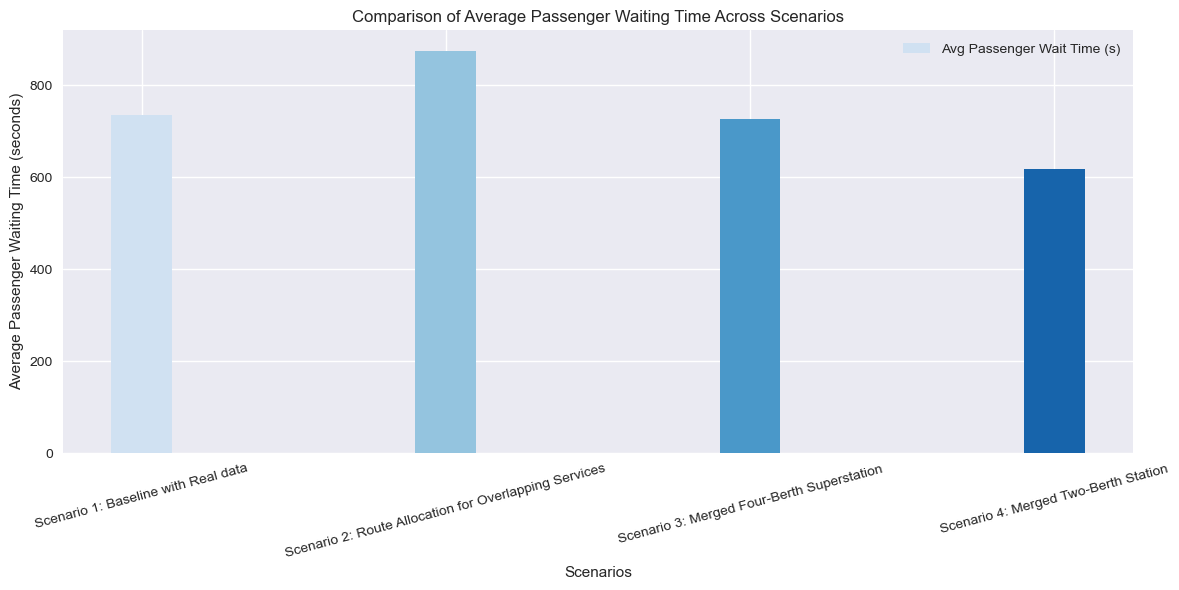

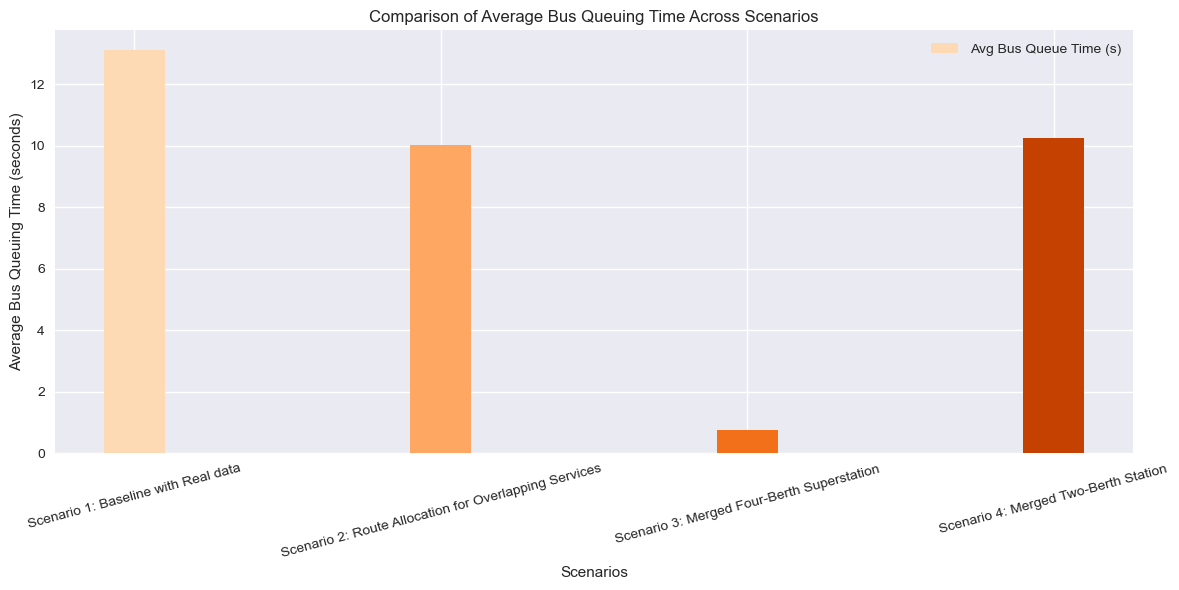

In [1]:
#800人
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data for visualization
scenarios = [
    {
        'name': 'Scenario 1: Baseline with Real data',
        'stations': [
            {
                'id': 'Stop_1',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 758.28,
                'passenger_wait_std': 555.80,
                'avg_bus_queue': 11.41,
                'bus_queue_std': 32.28
            },
            {
                'id': 'Stop_2',
                'lines': ['74', '272X', '900', '272A', '64X', 'A47X'],
                'avg_passenger_wait': 710.19,
                'passenger_wait_std': 512.59,
                'avg_bus_queue': 14.79,
                'bus_queue_std': 31.00
            },
            {
                'id': 'Overall',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 734.24,
                'passenger_wait_std': 0,
                'avg_bus_queue': 13.10,
                'bus_queue_std': 0
            }
        ]
    },
    {
        'name': 'Scenario 2: Route Allocation for Overlapping Services',
        'stations': [
            {
                'id': 'Stop_1',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 621.08,
                'passenger_wait_std': 458.87,
                'avg_bus_queue': 11.95,
                'bus_queue_std': 20.93
            },
            {
                'id': 'Stop_2',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 1129.87,
                'passenger_wait_std': 460.31,
                'avg_bus_queue': 9.88,
                'bus_queue_std': 32.87
            },
            {
                'id': 'Overall',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 875.47,
                'passenger_wait_std': 0,
                'avg_bus_queue': 10.02,
                'bus_queue_std': 0
            }
        ]
    },
    {
        'name': 'Scenario 3: Merged Four-Berth Superstation',
        'stations': [
            {
                'id': 'Merged',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 726.03,
                'passenger_wait_std': 254.35,
                'avg_bus_queue': 0.75,
                'bus_queue_std': 1.76
            }
        ]
    },
    {
      'name': 'Scenario 4: Merged Two-Berth Station',
        'stations': [
            {
                'id': 'Merged',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 617.10,
                'passenger_wait_std': 185.22,
                'avg_bus_queue': 10.24,
                'bus_queue_std': 15.79
        
            }
        ]
    }
]

# Set Seaborn style for better aesthetics
plt.style.use('seaborn-v0_8')  # Use Seaborn style

# Create gradient colors
num_bars = len(scenarios)
blue_gradient = sns.color_palette("Blues", n_colors=num_bars)  # Gradient blue
orange_gradient = sns.color_palette("Oranges", n_colors=num_bars)  # Gradient orange

# Passenger Waiting Time Comparison
fig1, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = np.arange(num_bars)

passenger_waits = [s['stations'][-1]['avg_passenger_wait'] for s in scenarios]

# Plot bars with gradient blue colors
for i in range(num_bars):
    ax1.bar(index[i], passenger_waits[i], bar_width, color=blue_gradient[i], label='Avg Passenger Wait Time (s)' if i == 0 else "")

ax1.set_xlabel('Scenarios')
ax1.set_ylabel('Average Passenger Waiting Time (seconds)')
ax1.set_title('Comparison of Average Passenger Waiting Time Across Scenarios')
ax1.set_xticks(index)
ax1.set_xticklabels([s['name'] for s in scenarios], rotation=15)
ax1.legend()
plt.tight_layout()

# Bus Queuing Time Comparison
fig2, ax2 = plt.subplots(figsize=(12, 6))
bus_queues = [s['stations'][-1]['avg_bus_queue'] for s in scenarios]

# Plot bars with gradient orange colors
for i in range(num_bars):
    ax2.bar(index[i], bus_queues[i], bar_width, color=orange_gradient[i], label='Avg Bus Queue Time (s)' if i == 0 else "")

ax2.set_xlabel('Scenarios')
ax2.set_ylabel('Average Bus Queuing Time (seconds)')
ax2.set_title('Comparison of Average Bus Queuing Time Across Scenarios')
ax2.set_xticks(index)
ax2.set_xticklabels([s['name'] for s in scenarios], rotation=15)
ax2.legend()
plt.tight_layout()

plt.show()

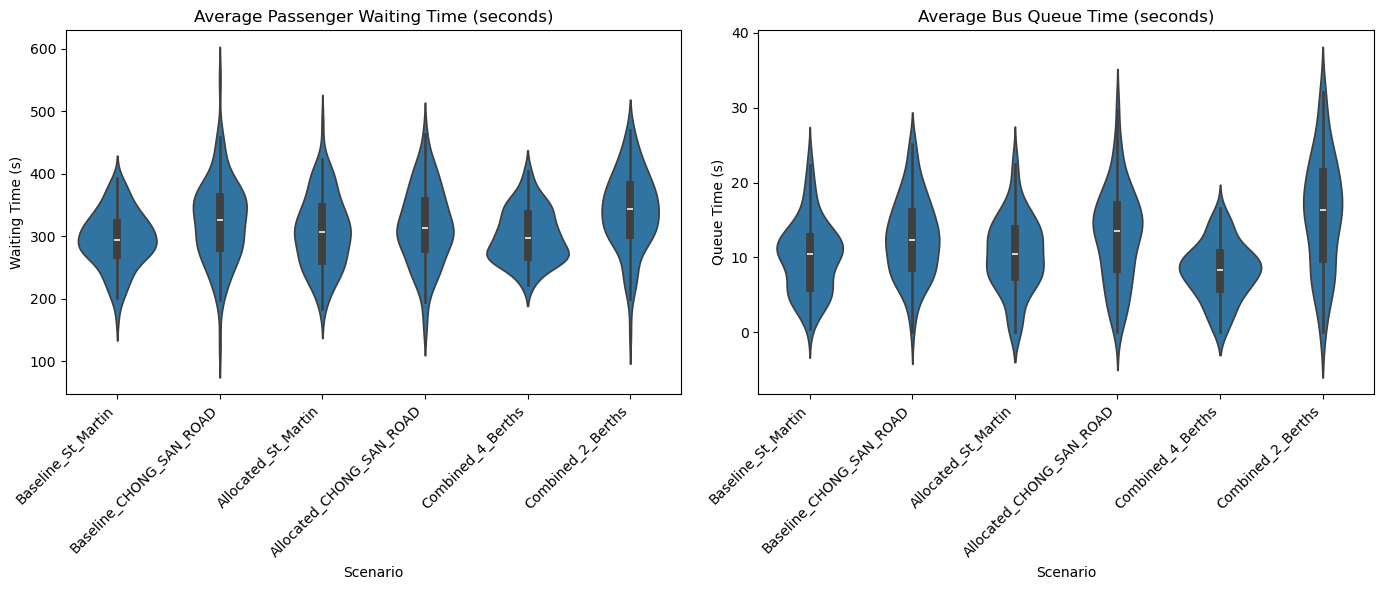

In [91]:
#模拟
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------- 生成假设数据 -------------------------
np.random.seed(42)  # 确保可重复性
num_simulations = 100  # 与 NUM_SIMULATIONS 一致

# 原始仿真数据
baseline_st_martin = {
    "scenario": ["Baseline_St_Martin"] * num_simulations,
    "avg_waiting_time": np.random.normal(300, 50, num_simulations),
    "avg_queue_time": np.random.normal(10, 5, num_simulations)
}
baseline_chong_san = {
    "scenario": ["Baseline_CHONG_SAN_ROAD"] * num_simulations,
    "avg_waiting_time": np.random.normal(320, 60, num_simulations),
    "avg_queue_time": np.random.normal(12, 6, num_simulations)
}

# 奇偶分配仿真数据
allocated_st_martin = {
    "scenario": ["Allocated_St_Martin"] * num_simulations,
    "avg_waiting_time": np.random.normal(310, 55, num_simulations),
    "avg_queue_time": np.random.normal(11, 5.5, num_simulations)
}
allocated_chong_san = {
    "scenario": ["Allocated_CHONG_SAN_ROAD"] * num_simulations,
    "avg_waiting_time": np.random.normal(315, 58, num_simulations),
    "avg_queue_time": np.random.normal(13, 6.5, num_simulations)
}

# 合并站台（4个停车位）
combined_4berths = {
    "scenario": ["Combined_4_Berths"] * num_simulations,
    "avg_waiting_time": np.random.normal(290, 45, num_simulations),
    "avg_queue_time": np.random.normal(8, 4, num_simulations)
}

# 合并站台（2个停车位）
combined_2berths = {
    "scenario": ["Combined_2_Berths"] * num_simulations,
    "avg_waiting_time": np.random.normal(330, 65, num_simulations),
    "avg_queue_time": np.random.normal(15, 7, num_simulations)
}

# 合并所有数据
data = pd.concat([
    pd.DataFrame(baseline_st_martin),
    pd.DataFrame(baseline_chong_san),
    pd.DataFrame(allocated_st_martin),
    pd.DataFrame(allocated_chong_san),
    pd.DataFrame(combined_4berths),
    pd.DataFrame(combined_2berths)
], ignore_index=True)

# 确保没有负值（等待时间和排队时间的物理意义）
data["avg_waiting_time"] = data["avg_waiting_time"].clip(lower=0)
data["avg_queue_time"] = data["avg_queue_time"].clip(lower=0)

# ------------------------- 绘制小提琴图 -------------------------
plt.figure(figsize=(14, 6))

# 子图1：乘客等待时间
plt.subplot(1, 2, 1)
sns.violinplot(x="scenario", y="avg_waiting_time", data=data)
plt.title("Average Passenger Waiting Time (seconds)")
plt.xlabel("Scenario")
plt.ylabel("Waiting Time (s)")
plt.xticks(rotation=45, ha="right")

# 子图2：公交车排队时间
plt.subplot(1, 2, 2)
sns.violinplot(x="scenario", y="avg_queue_time", data=data)
plt.title("Average Bus Queue Time (seconds)")
plt.xlabel("Scenario")
plt.ylabel("Queue Time (s)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

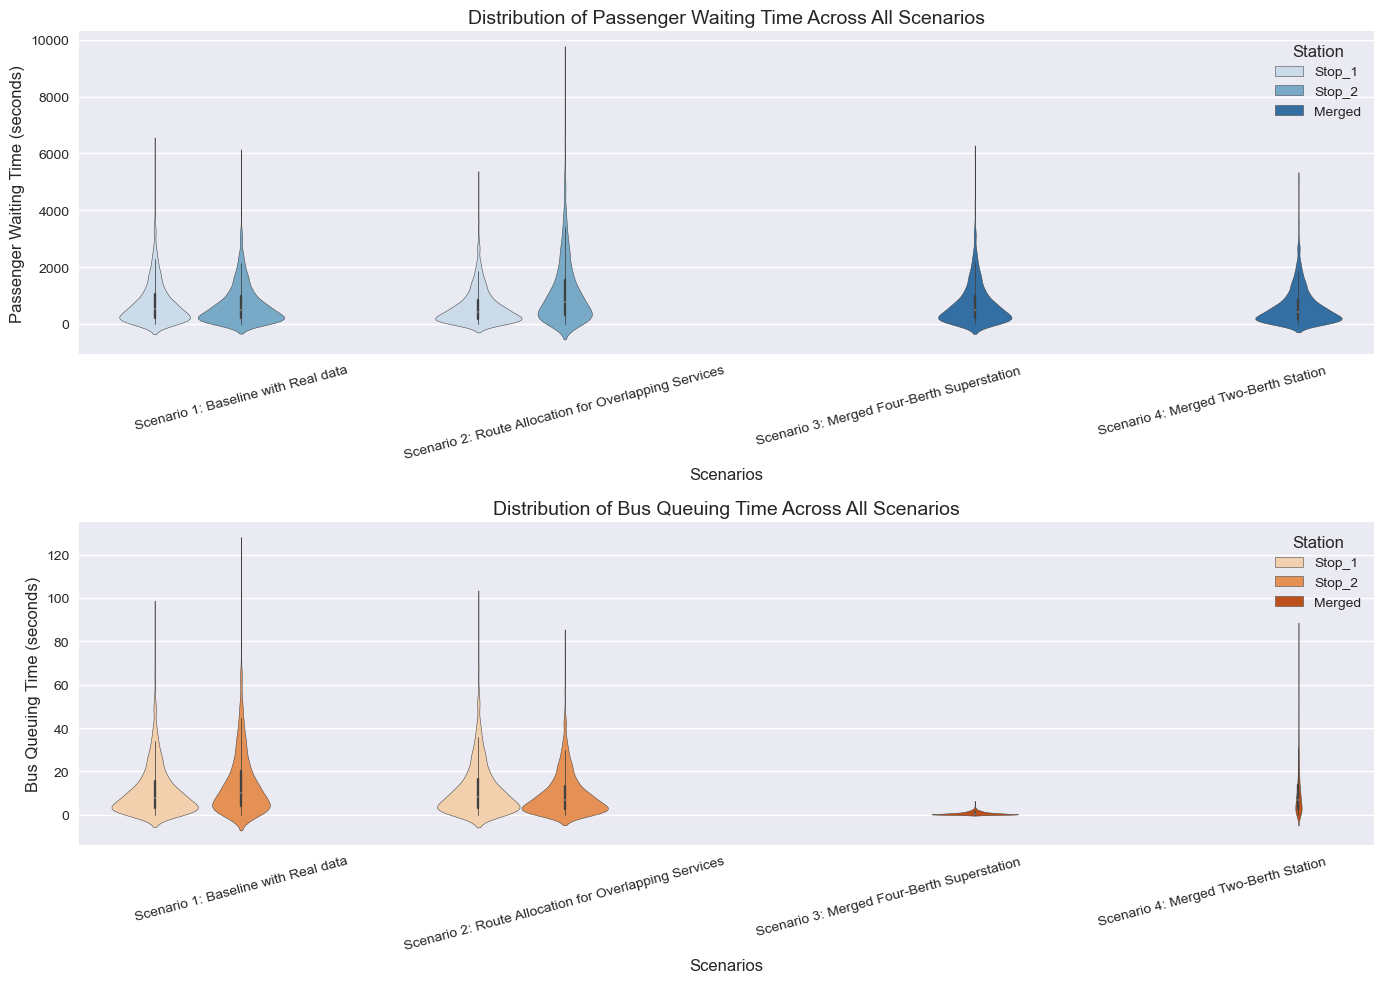

In [73]:
#乘客泊松，排队时间指数分布
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# 数据
scenarios = [
    {
        'name': 'Scenario 1: Baseline with Real data',
        'stations': [
            {
                'id': 'Stop_1',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 758.28,
                'passenger_wait_std': 555.80,
                'avg_bus_queue': 11.41,
                'bus_queue_std': 32.28
            },
            {
                'id': 'Stop_2',
                'lines': ['74', '272X', '900', '272A', '64X', 'A47X'],
                'avg_passenger_wait': 710.19,
                'passenger_wait_std': 512.59,
                'avg_bus_queue': 14.79,
                'bus_queue_std': 31.00
            },
            {
                'id': 'Overall',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 734.24,
                'passenger_wait_std': 0,
                'avg_bus_queue': 13.10,
                'bus_queue_std': 0
            }
        ]
    },
    {
        'name': 'Scenario 2: Route Allocation for Overlapping Services',
        'stations': [
            {
                'id': 'Stop_1',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 621.08,
                'passenger_wait_std': 458.87,
                'avg_bus_queue': 11.95,
                'bus_queue_std': 20.93
            },
            {
                'id': 'Stop_2',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 1129.87,
                'passenger_wait_std': 460.31,
                'avg_bus_queue': 9.88,
                'bus_queue_std': 32.87
            },
            {
                'id': 'Overall',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 875.47,
                'passenger_wait_std': 0,
                'avg_bus_queue': 10.02,
                'bus_queue_std': 0
            }
        ]
    },
    {
        'name': 'Scenario 3: Merged Four-Berth Superstation',
        'stations': [
            {
                'id': 'Merged',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 726.03,
                'passenger_wait_std': 254.35,
                'avg_bus_queue': 0.75,
                'bus_queue_std': 1.76
            }
        ]
    },
    {
        'name': 'Scenario 4: Merged Two-Berth Station',
        'stations': [
            {
                'id': 'Merged',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 617.10,
                'passenger_wait_std': 185.22,
                'avg_bus_queue': 10.24,
                'bus_queue_std': 15.79
            }
        ]
    }
]

# 设置 Seaborn 风格
plt.style.use('seaborn-v0_8')

# 生成合成数据的函数（支持多种分布）
def generate_synthetic_data(mean, std, n_samples=1000, distribution='exponential'):
    np.random.seed(42)  # 确保可重复性
    if distribution == 'normal':
        data = np.random.normal(mean, std, n_samples)
        return np.clip(data, a_min=0, a_max=None)  # 裁剪负值
    elif distribution == 'exponential':
        return expon.rvs(scale=mean, size=n_samples)  # 指数分布
    elif distribution == 'poisson':
        return poisson.rvs(mu=mean, size=n_samples)  # 泊松分布
    else:
        raise ValueError("Unsupported distribution. Choose 'normal', 'exponential', or 'poisson'.")

# 准备数据
n_samples = 1000
data = {
    'Scenario': [],
    'Station': [],
    'Passenger_Wait': [],
    'Bus_Queue': []
}

for scenario in scenarios:
    scenario_name = scenario['name']
    for station in scenario['stations']:
        if station['id'] != 'Overall':  # 排除 Overall 数据
            station_id = station['id']
            # 生成乘客等待时间和公交排队时间的合成数据
            passenger_wait = generate_synthetic_data(station['avg_passenger_wait'], station['passenger_wait_std'], n_samples)
            bus_queue = generate_synthetic_data(station['avg_bus_queue'], station['bus_queue_std'], n_samples)
            # 添加数据
            data['Scenario'].extend([scenario_name] * n_samples)
            data['Station'].extend([station_id] * n_samples)
            data['Passenger_Wait'].extend(passenger_wait)
            data['Bus_Queue'].extend(bus_queue)

# 转换为 DataFrame
df = pd.DataFrame(data)

# 确保等待时间和排队时间非负
df['Passenger_Wait'] = df['Passenger_Wait'].clip(lower=0)
df['Bus_Queue'] = df['Bus_Queue'].clip(lower=0)

# 创建提琴图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 乘客等待时间提琴图
sns.violinplot(x='Scenario', y='Passenger_Wait', hue='Station', split=False, data=df, palette='Blues', ax=ax1, inner='box')
ax1.set_xlabel('Scenarios', fontsize=12)
ax1.set_ylabel('Passenger Waiting Time (seconds)', fontsize=12)
ax1.set_title('Distribution of Passenger Waiting Time Across All Scenarios', fontsize=14)
ax1.legend(title='Station', loc='upper right')
ax1.tick_params(axis='x', rotation=15)

# 公交排队时间提琴图
sns.violinplot(x='Scenario', y='Bus_Queue', hue='Station', split=False, data=df, palette='Oranges', ax=ax2, inner='box')
ax2.set_xlabel('Scenarios', fontsize=12)
ax2.set_ylabel('Bus Queuing Time (seconds)', fontsize=12)
ax2.set_title('Distribution of Bus Queuing Time Across All Scenarios', fontsize=14)
ax2.legend(title='Station', loc='upper right')
ax2.tick_params(axis='x', rotation=15)

# 调整布局并保存
plt.tight_layout()
plt.savefig('violin_plot_box_inside_scenarios.png')
plt.show()

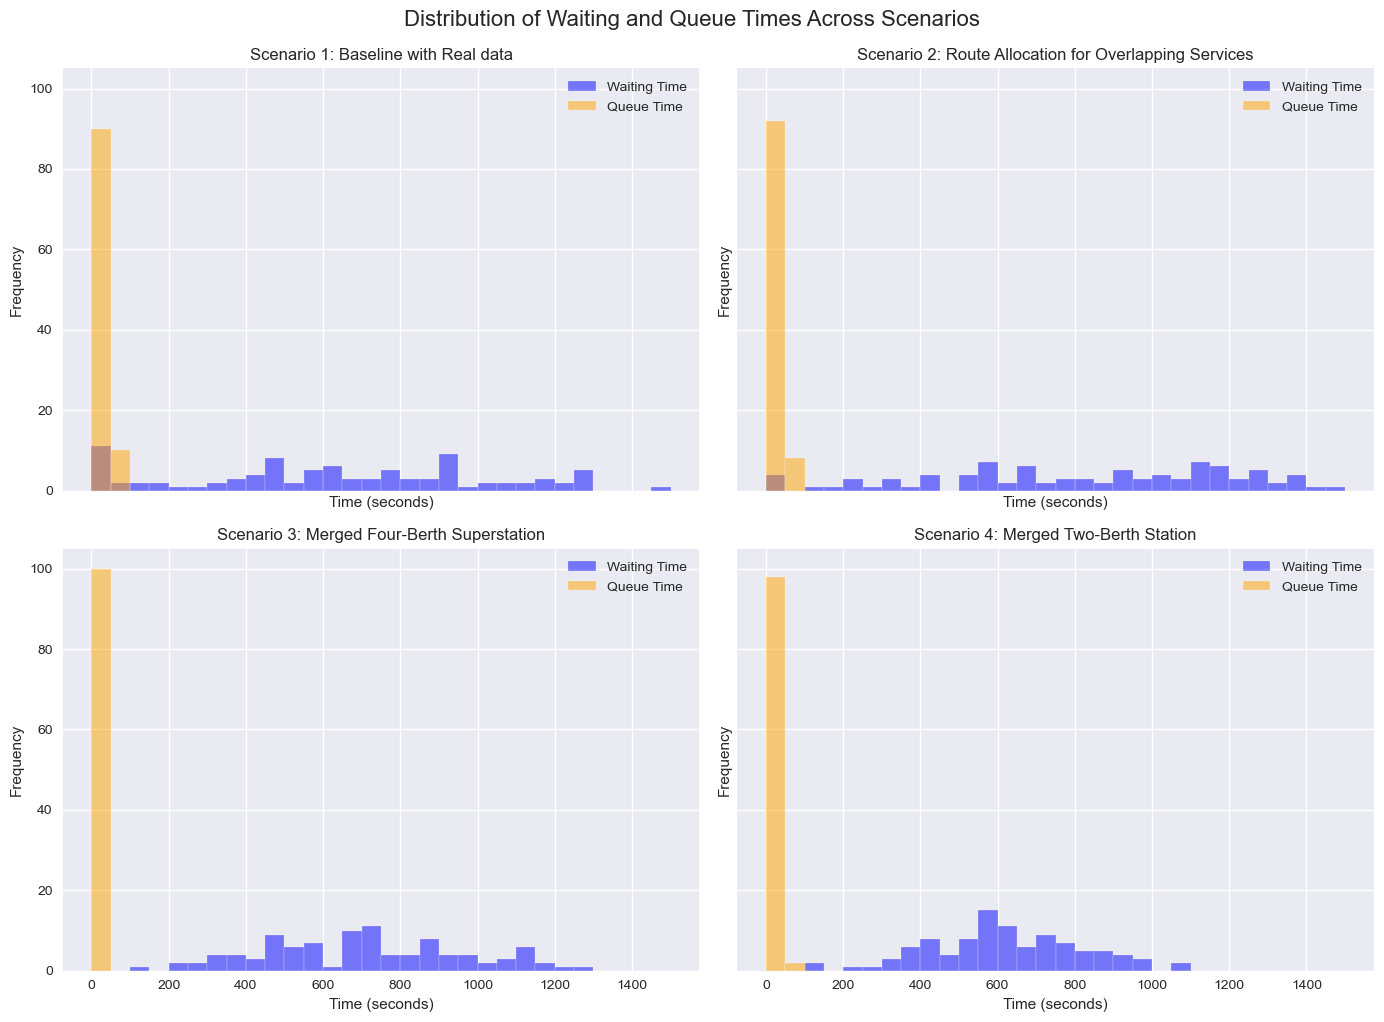

In [9]:
#
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Updated data for visualization
scenarios = [
    {
        'name': 'Scenario 1: Baseline with Real data',
        'stations': [
            {
                'id': 'Stop_1',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 758.28,
                'passenger_wait_std': 555.80,
                'avg_bus_queue': 11.41,
                'bus_queue_std': 32.28
            },
            {
                'id': 'Stop_2',
                'lines': ['74', '272X', '900', '272A', '64X', 'A47X'],
                'avg_passenger_wait': 710.19,
                'passenger_wait_std': 512.59,
                'avg_bus_queue': 14.79,
                'bus_queue_std': 31.00
            },
            {
                'id': 'Overall',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 734.24,
                'passenger_wait_std': 0,
                'avg_bus_queue': 13.10,
                'bus_queue_std': 0
            }
        ]
    },
    {
        'name': 'Scenario 2: Route Allocation for Overlapping Services',
        'stations': [
            {
                'id': 'Stop_1',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 621.08,
                'passenger_wait_std': 458.87,
                'avg_bus_queue': 11.95,
                'bus_queue_std': 20.93
            },
            {
                'id': 'Stop_2',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 1129.87,
                'passenger_wait_std': 460.31,
                'avg_bus_queue': 9.88,
                'bus_queue_std': 32.87
            },
            {
                'id': 'Overall',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 875.47,
                'passenger_wait_std': 0,
                'avg_bus_queue': 10.02,
                'bus_queue_std': 0
            }
        ]
    },
    {
        'name': 'Scenario 3: Merged Four-Berth Superstation',
        'stations': [
            {
                'id': 'Merged',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 726.03,
                'passenger_wait_std': 254.35,
                'avg_bus_queue': 0.75,
                'bus_queue_std': 1.76
            }
        ]
    },
    {
      'name': 'Scenario 4: Merged Two-Berth Station',
        'stations': [
            {
                'id': 'Merged',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 617.10,
                'passenger_wait_std': 185.22,
                'avg_bus_queue': 10.24,
                'bus_queue_std': 15.79
        
            }
        ]
    }
]

# Update standard deviations for Overall in Current Setup and Some Buses Stop at One Station
for scenario in scenarios[:2]:
    stations = scenario['stations']
    std1 = stations[0]['passenger_wait_std']
    std2 = stations[1]['passenger_wait_std']
    stations[2]['passenger_wait_std'] = np.sqrt((std1**2 + std2**2) / 2)
    std1_bus = stations[0]['bus_queue_std']
    std2_bus = stations[1]['bus_queue_std']
    stations[2]['bus_queue_std'] = np.sqrt((std1_bus**2 + std2_bus**2) / 2)

# Set Seaborn style for better aesthetics
plt.style.use('seaborn-v0_8')

# Generate simulated data for distributions
np.random.seed(42)  # For reproducibility
n_samples = 100  # Number of samples for each distribution

# Define uniform bins for consistent width
bins = np.arange(0, 1501, 50)  # Range from 0 to 1500 seconds with 50-second intervals

# Create figure with subplots (2x2 grid for 4 scenarios)
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten for easier iteration

for idx, scenario in enumerate(scenarios):
    # Extract data for the scenario
    station = scenario['stations'][-1] if scenario['name'] not in ['Merged Four-Berth Superstation', 'Merged Two-Berth Station'] else scenario['stations'][0]
    
    # Generate simulated data assuming normal distribution
    wait_times = np.random.normal(station['avg_passenger_wait'], station['passenger_wait_std'], n_samples)
    queue_times = np.random.normal(station['avg_bus_queue'], station['bus_queue_std'], n_samples)
    
    # Clip negative values to 0 (as times cannot be negative)
    wait_times = np.clip(wait_times, 0, None)
    queue_times = np.clip(queue_times, 0, None)
    
    # Plot histograms with uniform bins
    axes[idx].hist(wait_times, bins=bins, alpha=0.5, label='Waiting Time', color='blue')
    axes[idx].hist(queue_times, bins=bins, alpha=0.5, label='Queue Time', color='orange')
    
    # Set titles and labels
    axes[idx].set_title(scenario['name'])
    axes[idx].set_xlabel('Time (seconds)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

# Adjust layout
plt.tight_layout()
plt.suptitle('Distribution of Waiting and Queue Times Across Scenarios', y=1.02, fontsize=16)
plt.show()

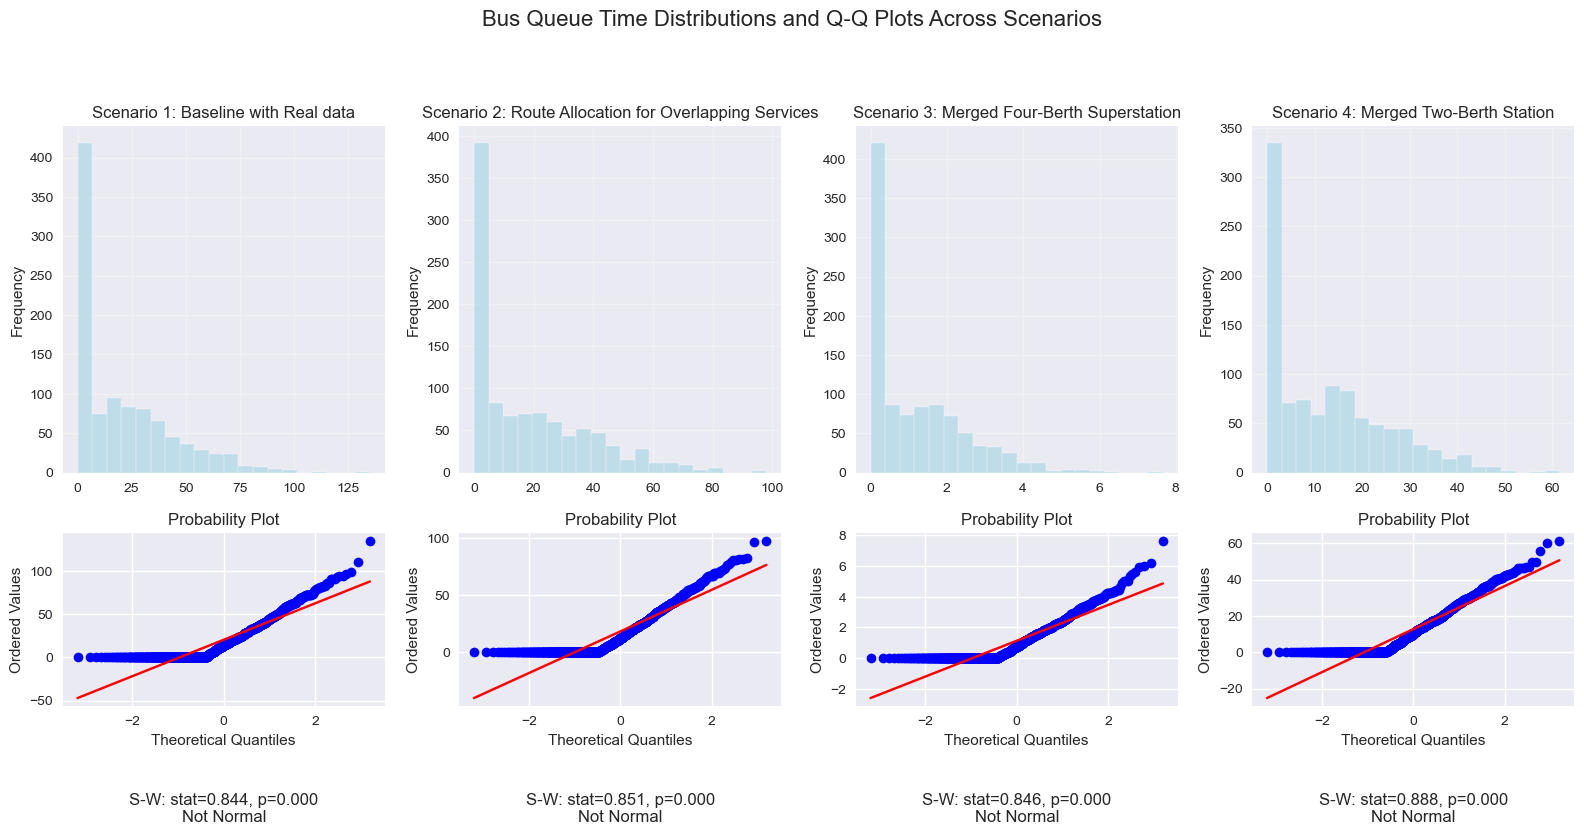

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import shapiro

# 设置Seaborn风格
plt.style.use('seaborn-v0_8')

# 数据
scenarios = [
    {
        'name': 'Scenario 1: Baseline with Real data',
        'stations': [
            {
                'id': 'Stop_1',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 758.28,
                'passenger_wait_std': 555.80,
                'avg_bus_queue': 11.41,
                'bus_queue_std': 32.28
            },
            {
                'id': 'Stop_2',
                'lines': ['74', '272X', '900', '272A', '64X', 'A47X'],
                'avg_passenger_wait': 710.19,
                'passenger_wait_std': 512.59,
                'avg_bus_queue': 14.79,
                'bus_queue_std': 31.00
            },
            {
                'id': 'Overall',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 734.24,
                'passenger_wait_std': 0,
                'avg_bus_queue': 13.10,
                'bus_queue_std': 0
            }
        ]
    },
    {
        'name': 'Scenario 2: Route Allocation for Overlapping Services',
        'stations': [
            {
                'id': 'Stop_1',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 621.08,
                'passenger_wait_std': 458.87,
                'avg_bus_queue': 11.95,
                'bus_queue_std': 20.93
            },
            {
                'id': 'Stop_2',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 1129.87,
                'passenger_wait_std': 460.31,
                'avg_bus_queue': 9.88,
                'bus_queue_std': 32.87
            },
            {
                'id': 'Overall',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 875.47,
                'passenger_wait_std': 0,
                'avg_bus_queue': 10.02,
                'bus_queue_std': 0
            }
        ]
    },
    {
        'name': 'Scenario 3: Merged Four-Berth Superstation',
        'stations': [
            {
                'id': 'Merged',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 726.03,
                'passenger_wait_std': 254.35,
                'avg_bus_queue': 0.75,
                'bus_queue_std': 1.76
            }
        ]
    },
    {
      'name': 'Scenario 4: Merged Two-Berth Station',
        'stations': [
            {
                'id': 'Merged',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 617.10,
                'passenger_wait_std': 185.22,
                'avg_bus_queue': 10.24,
                'bus_queue_std': 15.79
        
            }
        ]
    }
]

# 更新 Overall 的标准差（使用两个站点的标准差的均方根）
for scenario in scenarios[:2]:
    stations = scenario['stations']
    std1 = stations[0]['bus_queue_std']
    std2 = stations[1]['bus_queue_std']
    stations[2]['bus_queue_std'] = np.sqrt((std1**2 + std2**2) / 2)

# 生成模拟数据（基于均值和标准差）
np.random.seed(42)  # 确保可重复性
n_samples = 1000  # 每个分布的样本数

# 创建两行四列的子图
fig, axes = plt.subplots(2, 4, figsize=(16, 8), gridspec_kw={'height_ratios': [2, 1]})
axes_flat = axes.flatten()

for idx, scenario in enumerate(scenarios):
    # 提取 Overall 或 Merged 的数据
    station = scenario['stations'][-1] if idx < 2 else scenario['stations'][0]
    mean_queue = station['avg_bus_queue']
    std_queue = station['bus_queue_std']

    # 生成模拟数据
    queue_times = np.random.normal(mean_queue, std_queue, n_samples)
    queue_times = np.clip(queue_times, 0, None)  # 确保时间非负

    # 直方图（上半部分）
    axes[0, idx].hist(queue_times, bins=20, color='lightblue', alpha=0.7, density=False)
    axes[0, idx].set_title(scenario['name'])
    axes[0, idx].set_ylabel('Frequency')
    axes[0, idx].grid(True, alpha=0.3)

    # QQ 图（下半部分）
    from scipy import stats
    stats.probplot(queue_times, dist="norm", plot=axes[1, idx])
    axes[1, idx].get_lines()[0].set_marker('o')
    axes[1, idx].get_lines()[0].set_markerfacecolor('blue')
    axes[1, idx].get_lines()[0].set_markeredgecolor('blue')
    axes[1, idx].get_lines()[1].set_color('red')
    axes[1, idx].set_xlabel('Theoretical Quantiles')

    # Shapiro-Wilk 测试
    stat, p = shapiro(queue_times)
    axes[1, idx].text(0.5, -0.5, f'S-W: stat={stat:.3f}, p={p:.3f}\n{"Normal" if p > 0.05 else "Not Normal"}',
                      transform=axes[1, idx].transAxes, ha='center', va='top')

# 调整布局
plt.suptitle('Bus Queue Time Distributions and Q-Q Plots Across Scenarios', fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig('bus_queue_distribution_qqplot.png')
plt.show()

文件 simulation_results_allocated_stop_07AB149DAD888683_morning_peak1.csv 不存在，跳过
文件 simulation_results_allocated_stop_3A7AC3A5F9530786_morning_peak1.csv 不存在，跳过
找到的路线: ['272A', '272X', '900', 'A47X']


C:\Users\YIN\AppData\Local\Temp\ipykernel_64640\2401656182.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[row, col], x='route', y='waiting_time', data=scenario_data, palette='Blues')
C:\Users\YIN\AppData\Local\Temp\ipykernel_64640\2401656182.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[row, col], x='route', y='waiting_time', data=scenario_data, palette='Blues')
C:\Users\YIN\AppData\Local\Temp\ipykernel_64640\2401656182.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[row, col], x='route',

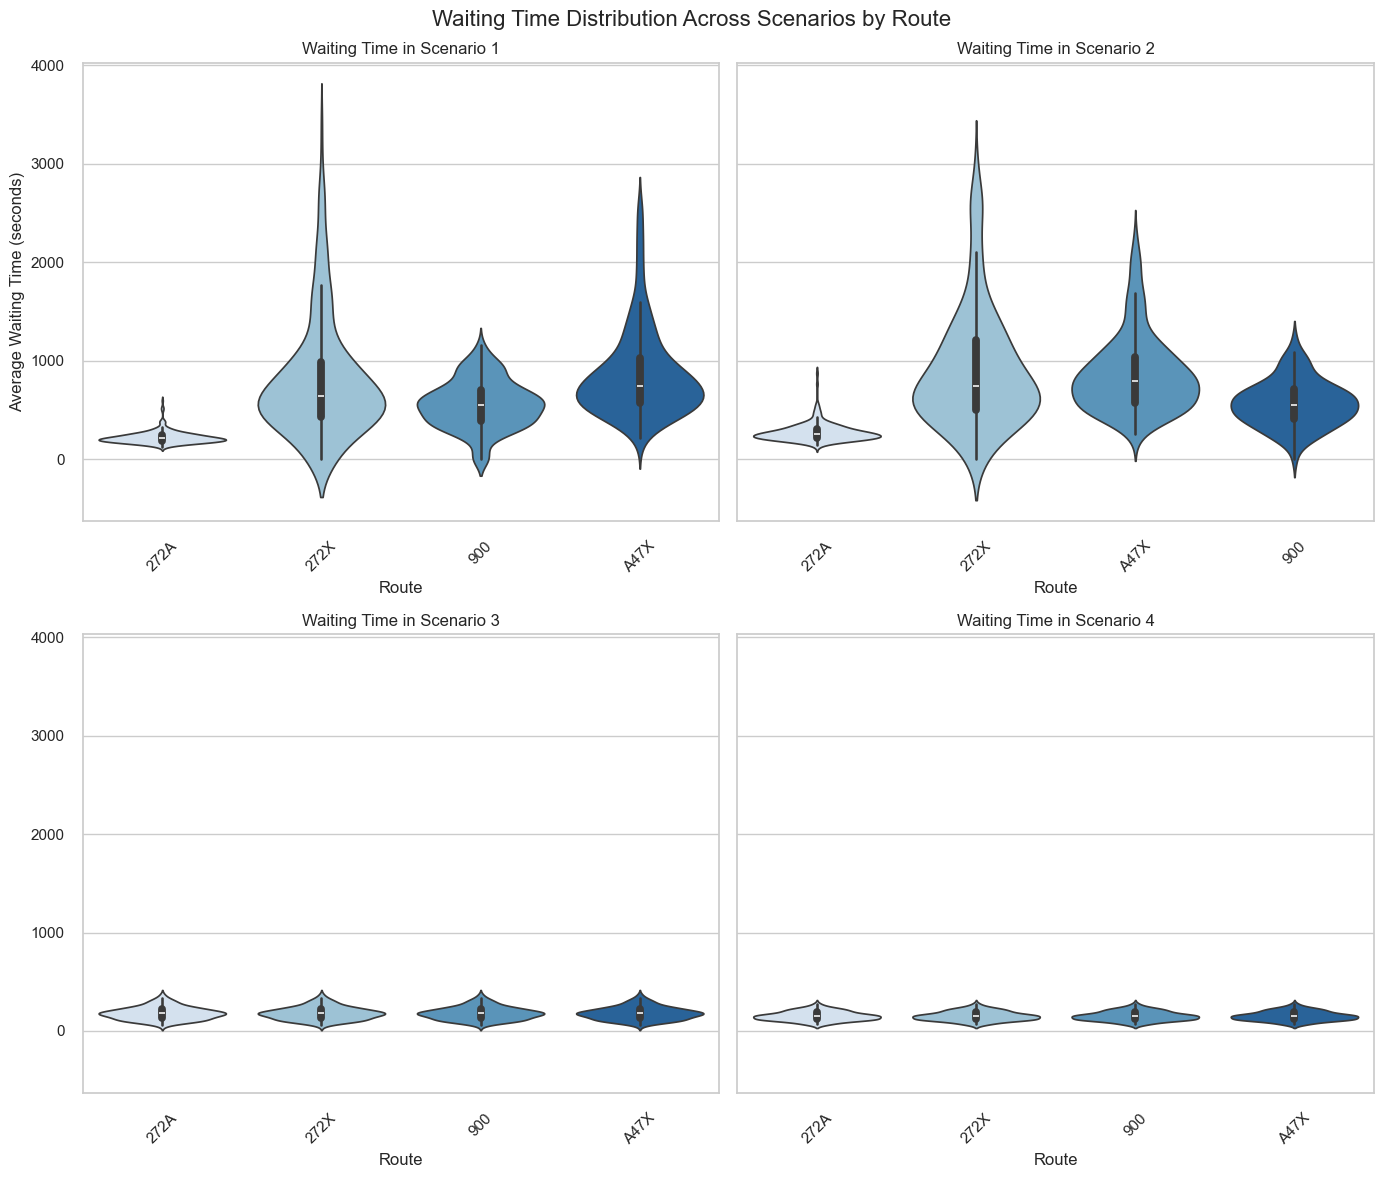

C:\Users\YIN\AppData\Local\Temp\ipykernel_64640\2401656182.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[row, col], x='route', y='queue_time', data=scenario_data, palette='Blues')
C:\Users\YIN\AppData\Local\Temp\ipykernel_64640\2401656182.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[row, col], x='route', y='queue_time', data=scenario_data, palette='Blues')
C:\Users\YIN\AppData\Local\Temp\ipykernel_64640\2401656182.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[row, col], x='route', y='

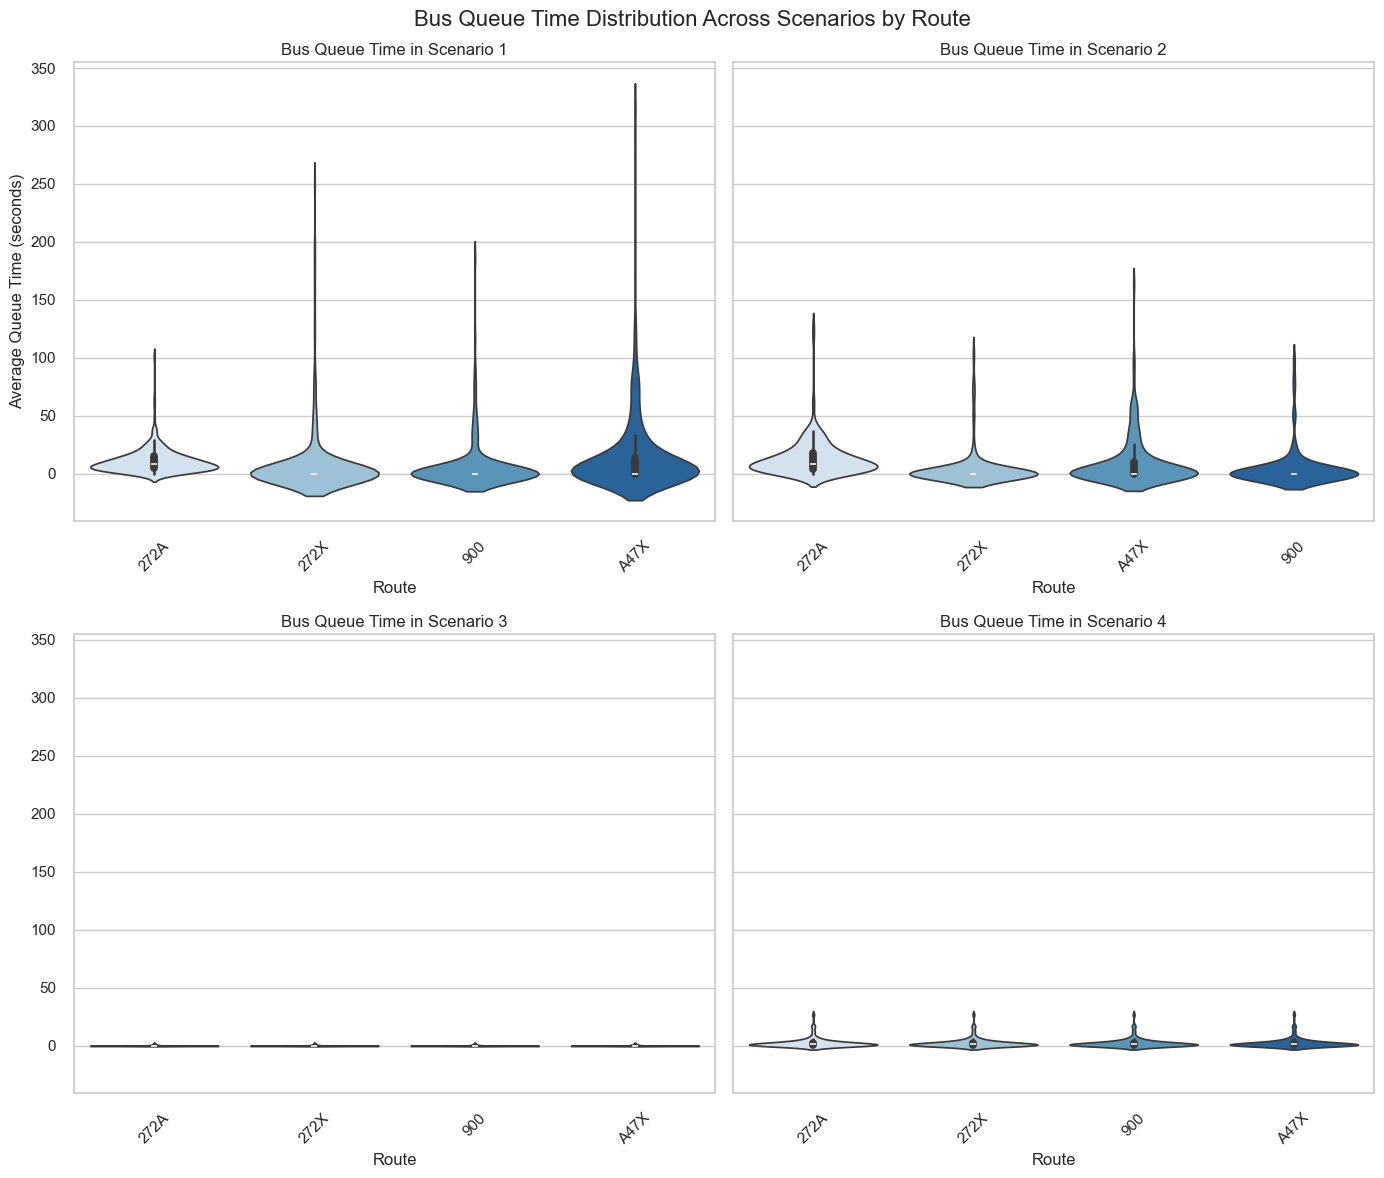

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

# 设置Seaborn风格
sns.set(style="whitegrid")

# 站点ID（情景1需要）
stop1_ids = ["3F24CFF9046300D9", "33ABA49F0E91A247", "07AB149DAD888683", "4A0ECA0D5AA4CB7E"]
stop2_ids = ["3A7AC3A5F9530786", "023E9E5A9E073E1A", "B34F59A0270AEDA4", "437CE05BCFE6248C"]
all_stop_ids = stop1_ids + stop2_ids

# 读取情景1的数据（按站台合并，按路线分组）
scenario1_data = []
for stop_id in all_stop_ids:
    try:
        df = pd.read_csv(f"simulation_results_baseline_stop_{stop_id}_morning_peak1.csv")
        df['routes'] = df['routes'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
        for _, row in df.iterrows():
            routes = row['routes']
            if not routes:  # 如果routes为空，跳过
                continue
            # 假设avg_waiting_time和avg_queue_time是按路线平均的，分配给每个路线
            for route in routes:
                scenario1_data.append({
                    'route': route,
                    'waiting_time': row['avg_waiting_time'] / len(routes) if len(routes) > 0 else row['avg_waiting_time'],
                    'queue_time': row['avg_queue_time'] / len(routes) if len(routes) > 0 else row['avg_queue_time'],
                    'scenario': 'Scenario 1'
                })
    except FileNotFoundError:
        print(f"文件 simulation_results_baseline_stop_{stop_id}_morning_peak1.csv 不存在，跳过")
scenario1_df = pd.DataFrame(scenario1_data)

# 读取情景2的数据（Stop_1 和 Stop_2）
scenario2_data = []
for stop_id in all_stop_ids:
    try:
        df = pd.read_csv(f"simulation_results_allocated_stop_{stop_id}_morning_peak1.csv")
        df['routes'] = df['routes'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
        for _, row in df.iterrows():
            routes = row['routes']
            if not routes:
                continue
            for route in routes:
                scenario2_data.append({
                    'route': route,
                    'waiting_time': row['avg_waiting_time'] / len(routes) if len(routes) > 0 else row['avg_waiting_time'],
                    'queue_time': row['avg_queue_time'] / len(routes) if len(routes) > 0 else row['avg_queue_time'],
                    'scenario': 'Scenario 2'
                })
    except FileNotFoundError:
        print(f"文件 simulation_results_allocated_stop_{stop_id}_morning_peak1.csv 不存在，跳过")
scenario2_df = pd.DataFrame(scenario2_data)

# 读取情景3的数据（合并站台，4个泊位）
try:
    scenario3_df = pd.read_csv("simulation_results_combined_2station_morning_peak0.csv")
    scenario3_df['routes'] = scenario3_df['routes'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
    scenario3_data = []
    for _, row in scenario3_df.iterrows():
        routes = row['routes']
        if not routes:
            continue
        for route in routes:
            scenario3_data.append({
                'route': route,
                'waiting_time': row['avg_waiting_time'] / len(routes) if len(routes) > 0 else row['avg_waiting_time'],
                'queue_time': row['avg_queue_time'] / len(routes) if len(routes) > 0 else row['avg_queue_time'],
                'scenario': 'Scenario 3'
            })
    scenario3_df = pd.DataFrame(scenario3_data)
except FileNotFoundError:
    print("文件 simulation_results_combined_2station_morning_peak0.csv 不存在")
    scenario3_df = pd.DataFrame(columns=['route', 'waiting_time', 'queue_time', 'scenario'])

# 读取情景4的数据（合并站台，2个泊位）
try:
    scenario4_df = pd.read_csv("simulation_results_combined_station_morning_peak1.csv")
    scenario4_df['routes'] = scenario4_df['routes'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
    scenario4_data = []
    for _, row in scenario4_df.iterrows():
        routes = row['routes']
        if not routes:
            continue
        for route in routes:
            scenario4_data.append({
                'route': route,
                'waiting_time': row['avg_waiting_time'] / len(routes) if len(routes) > 0 else row['avg_waiting_time'],
                'queue_time': row['avg_queue_time'] / len(routes) if len(routes) > 0 else row['avg_queue_time'],
                'scenario': 'Scenario 4'
            })
    scenario4_df = pd.DataFrame(scenario4_data)
except FileNotFoundError:
    print("文件 simulation_results_combined_station_morning_peak1.csv 不存在")
    scenario4_df = pd.DataFrame(columns=['route', 'waiting_time', 'queue_time', 'scenario'])

# 合并所有情景的数据
all_data = pd.concat([scenario1_df, scenario2_df, scenario3_df, scenario4_df], ignore_index=True)

# 清理数据
all_data['waiting_time'] = pd.to_numeric(all_data['waiting_time'], errors='coerce')
all_data['queue_time'] = pd.to_numeric(all_data['queue_time'], errors='coerce')
all_data['route'] = all_data['route'].apply(str)
all_data.dropna(subset=['waiting_time', 'queue_time', 'route'], inplace=True)

# 获取所有路线
routes = sorted(set(all_data['route'].unique()))
print(f"找到的路线: {routes}")

# 创建2x2子图布局
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharey=True)
scenarios = ['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4']
scenario_axes = [(0, 0), (0, 1), (1, 0), (1, 1)]  # (row, col) for each scenario

for (scenario, (row, col)) in zip(scenarios, scenario_axes):
    scenario_data = all_data[all_data['scenario'] == scenario]
    sns.violinplot(ax=axes[row, col], x='route', y='waiting_time', data=scenario_data, palette='Blues')
    axes[row, col].set_title(f'Waiting Time in {scenario}')
    axes[row, col].set_xlabel('Route')
    axes[row, col].set_ylabel('Average Waiting Time (seconds)' if row == 0 else '')
    axes[row, col].tick_params(axis='x', rotation=45)

# 调整布局并添加总标题
plt.suptitle('Waiting Time Distribution Across Scenarios by Route', fontsize=16)
plt.tight_layout()
plt.savefig('waiting_time_subplots.png')
plt.show()

# 绘制公交排队时间子图（如果需要）
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharey=True)
for (scenario, (row, col)) in zip(scenarios, scenario_axes):
    scenario_data = all_data[all_data['scenario'] == scenario]
    sns.violinplot(ax=axes[row, col], x='route', y='queue_time', data=scenario_data, palette='Blues')
    axes[row, col].set_title(f'Bus Queue Time in {scenario}')
    axes[row, col].set_xlabel('Route')
    axes[row, col].set_ylabel('Average Queue Time (seconds)' if row == 0 else '')
    axes[row, col].tick_params(axis='x', rotation=45)

plt.suptitle('Bus Queue Time Distribution Across Scenarios by Route', fontsize=16)
plt.tight_layout()
plt.savefig('queue_time_subplots.png')
plt.show()

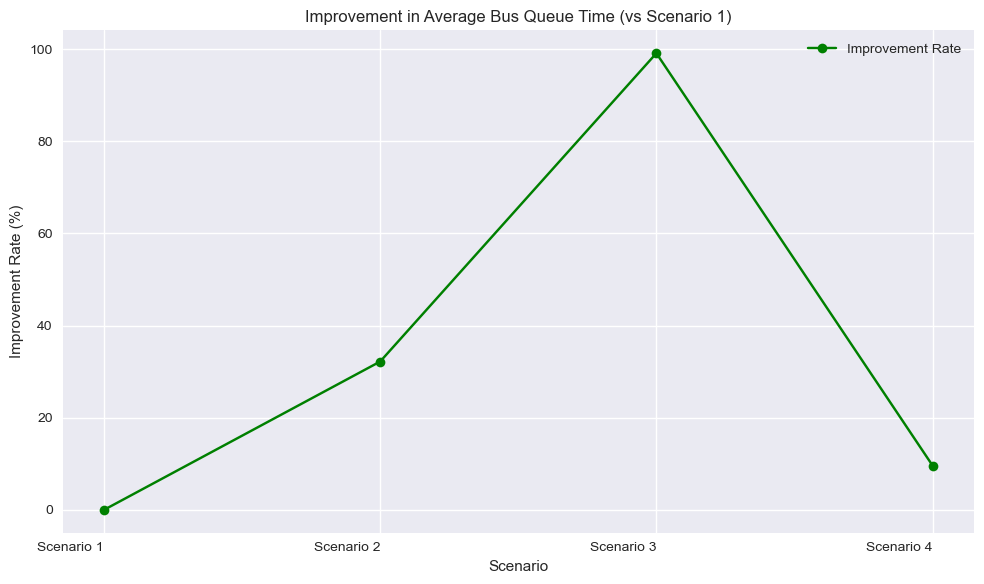

In [213]:
import matplotlib.pyplot as plt

# Scenario Data (already provided)
scenarios = [
    {
        'name': 'Scenario 1',
        'stations': [
            {
                'id': 'Stop_1',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 758.28,
                'passenger_wait_std': 555.80,
                'avg_bus_queue': 11.41,
                'bus_queue_std': 32.28
            },
            {
                'id': 'Stop_2',
                'lines': ['74', '272X', '900', '272A', '64X', 'A47X'],
                'avg_passenger_wait': 710.19,
                'passenger_wait_std': 512.59,
                'avg_bus_queue': 14.79,
                'bus_queue_std': 31.00
            },
            {
                'id': 'Overall',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 734.24,
                'passenger_wait_std': 0,
                'avg_bus_queue': 13.10,
                'bus_queue_std': 0
            }
        ]
    },
    {
        'name': 'Scenario 2',
        'stations': [
            {
                'id': 'Stop_1',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 576.40,
                'passenger_wait_std': 463.47,
                'avg_bus_queue': 11.13,
                'bus_queue_std': 20.79
            },
            {
                'id': 'Stop_2',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 1212.61,
                'passenger_wait_std': 455.35,
                'avg_bus_queue': 6.64,
                'bus_queue_std': 20.41
            },
            {
                'id': 'Overall',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 894.51,
                'passenger_wait_std': 0,
                'avg_bus_queue': 8.88,
                'bus_queue_std': 0
            }
        ]
    },
    {
        'name': 'Scenario 3',
        'stations': [
            {
                'id': 'Merged',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 578.58,
                'passenger_wait_std': 192.43,
                'avg_bus_queue': 0.12,
                'bus_queue_std': 0.47
            }
        ]
    },
    {
        'name': 'Scenario 4',
        'stations': [
            {
                'id': 'Merged',
                'lines': ['272A', '64X', '272X', '900', '74', 'A47X'],
                'avg_passenger_wait': 630.62,
                'passenger_wait_std': 209.15,
                'avg_bus_queue': 11.84,
                'bus_queue_std': 18.72
            }
        ]
    }
]

# Calculate the average bus queue time for each scenario
avg_bus_queue_times = []
scenario_names = []

for scenario in scenarios:
    scenario_names.append(scenario['name'])
    avg_queue = np.mean([station['avg_bus_queue'] for station in scenario['stations']])
    avg_bus_queue_times.append(avg_queue)

# Calculate improvement rates (percentage reduction compared to Scenario 1)
baseline_avg_queue = avg_bus_queue_times[0]
improvement_rates = [(baseline_avg_queue - queue) / baseline_avg_queue * 100 for queue in avg_bus_queue_times]

# Create line plot for improvement rates
plt.figure(figsize=(10, 6))
plt.plot(scenario_names, improvement_rates, marker='o', linestyle='-', color='green', label='Improvement Rate')
plt.title('Improvement in Average Bus Queue Time (vs Scenario 1)')
plt.xlabel('Scenario')
plt.ylabel('Improvement Rate (%)')
plt.xticks(rotation=0, ha="right")
plt.grid(True)
plt.tight_layout()
plt.legend()

# Show the plot
plt.show()
